<a href="https://colab.research.google.com/github/pierrickBERTHE/Projet7_OCR_DataScientist/blob/main/Berthe_Pierrick_3_notebook_modelisation_022024_VersionGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:SteelBlue'>P7 - Implémentez un modèle  de scoring (part 2)</span>

![Logo pret_a_depenser](https://user.oc-static.com/upload/2023/03/22/16794938722698_Data%20Scientist-P7-01-banner.png)

# <span style='background:white; color:black'>Sommaire</span>

**Introduction**

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

**Etape 1 : ...**

## <span style='background:red'>MAJ à faire</span>

**Conclusion**

# <span style='background:blue'>Introduction</span>

L'entreprise **"Prêt à dépenser"** souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un **algorithme de classification** en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).
___
**Missions**<br>
1/ Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

2/ Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

3/ Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

4/ Mettre en oeuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
___
Ce notebook presente la 2ème partie concernant la construction du modèle de scoring.

___

**Source des datasets**<br>
Home Credit est une institution financière internationale de prêts à la consommation. Elle nous fournit un jeu de données comportant des informations sur les clients, les crédits qu'ils ont contractés, leur revenus, etc. Ces données sont utilisées pour construire un modèle de scoring de crédit pour prédire la probabilité de capacité de remboursement d'un client, et donc de déterminer si un crédit doit lui être accordé ou non.

Source : [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview) sur Kaggle.com<br>

10 fichiers CSV :
- application_train.csv
- application_test.csv
- bureau.csv
- bureau_balance.csv
- credit_card_balance.csv
- HomeCredit_columns_description.csv
- installments_payments.csv
- POS_CASH_balance.csv
- previous_application.csv
- sample_submission.csv

Voici le diagramme entité-association des données (diagramme ERD) :

![mappage_dataset](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

# <span style='background:grey'>Importations des librairies utilisees dans ce notebook</span>

In [1]:
# pip install pour Google Colab
!pip install flake8 pycodestyle_magic --quiet
!pip install category-encoders --quiet
!pip install mlflow --quiet
!pip install scikit-optimize --quiet
!pip install shap --quiet
!pip install pyngrok --quiet

In [2]:
# Librairies générales
import sys
import os
import time
from datetime import datetime
import pickle
from IPython.display import display
import warnings
import gc
import joblib

# Data science
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# machine learning (général)
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
import shap

# machine learning (modèles)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Imbalanced-learn (Gestion des classes déséquilibrées)
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Encodage des variables
from category_encoders.target_encoder import TargetEncoder

# Optimisation des hyperparametres Bayesienne
import skopt
from skopt import BayesSearchCV

# mlflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Pour Google Colab
from google.colab import drive
drive.mount('/content/drive')
print("\nConnecté à Google Drive\n")

# Pour mlflow sur Google Colab
import subprocess
import pyngrok
from pyngrok import ngrok, conf
import getpass

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Imblearn      : " + imblearn.__version__)
print("Joblib        : " + joblib.__version__)
print("Matplotlib    : " + mpl.__version__)
print("Missingno     : " + msno.__version__)
print("MlFlow        : " + mlflow.__version__)
print("Numpy         : " + np.__version__)
print("Pandas        : " + pd.__version__)
print("Pyngrok       : " + pyngrok.__version__)
print("Scikit-learn  : " + sklearn.__version__)
print("Seaborn       : " + sns.__version__)    # type: ignore
print("Shap          : " + shap.__version__)
print("Skopt         : " + skopt.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Connecté à Google Drive

Version des librairies utilisees :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Imblearn      : 0.10.1
Joblib        : 1.3.2
Matplotlib    : 3.7.1
Missingno     : 0.5.2
MlFlow        : 2.11.1
Numpy         : 1.25.2
Pandas        : 1.5.3
Pyngrok       : 7.1.5
Scikit-learn  : 1.2.2
Seaborn       : 0.13.1
Shap          : 0.45.0
Skopt         : 0.10.0

Code lance le : 2024-03-14T14:37:39.549480



# <span style='background:grey'>Paramètres d'affichage</span>

In [3]:
# nombre ligne, col et chiffre apres la virgule
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 150)
pd.set_option("display.precision", 2)

# Ignore warnings
warnings.filterwarnings('ignore', category=UserWarning, module='distutils')
warnings.filterwarnings(
    'ignore',
    category=UserWarning,
    module='_distutils_hack'
)

# Graine aléatoire
random_seed = 42

# <span style='background:grey'>Fonctions</span>

In [4]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

In [5]:
def calcul_valeur_manquante(df):
    """
    Calcule le nombre total de valeurs manquantes dans le DataFrame.

    :param df: DataFrame à analyser
    :return: nombre total de valeurs manquantes, nombre total de données,
    pourcentage de valeurs manquantes
    """
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    return nb_nan_tot, nb_donnees_tot, nb_nan_pourcent

In [6]:
def calcul_valeur_manquante_table(df):
    """
    Crée une table des valeurs manquantes par colonne dans le DataFrame.

    :param df: DataFrame à analyser
    :return: DataFrame contenant le nombre et le pourcentage de valeurs
    manquantes par colonne
    """
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombre de valeurs manquantes', '% de valeurs manquantes']
    return table

In [7]:
def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Affiche le nombre de valeurs manquantes, un tableau de la répartition des
    valeurs manquantes par variable,
    et une matrice de répartition des valeurs manquantes par variable.

    :param df: DataFrame à analyser
    :param tableau: si True, affiche le tableau de répartition des valeurs
    manquantes
    :param matrice: si True, affiche la matrice de répartition des valeurs
    manquantes
    """
    # Affichage des valeurs manquantes
    nb_nan_tot, nb_donnees_tot, nb_nan_pourcent = calcul_valeur_manquante(df)
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(
        nb_nan_tot, nb_donnees_tot, nb_nan_pourcent
    ))

    # Affichage du tableau de répartition des valeurs manquantes
    table = calcul_valeur_manquante_table(df)
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombre de valeurs manquantes'] != 0][
        'Nombre de valeurs manquantes'].size
    print(f'{nb_col_nan} / {nb_col} colonne(s) concernée(s)')

    # Affichage du tableau de répartition des valeurs manquantes
    if tableau:
        display(
            table[table['Nombre de valeurs manquantes'] != 0]
            .sort_values('% de valeurs manquantes', ascending=False)
            .style.background_gradient('YlGn')
        )

    # Affichage de la matrice de répartition des valeurs manquantes
    if matrice:
        print("-" * 100)
        print("Heatmap de visualisation des valeurs manquantes")
        msno.matrix(df)

In [8]:
def plot_and_save_courbe_roc(y, y_prob, auc):
    """
    Trace et enregistre la courbe ROC.

    Paramètres
    ----------
    y : array-like
        Les vraies valeurs de la cible.
    y_prob : array-like
        Les probabilités prédites pour la classe positive.
    auc : float
        L'aire sous la courbe ROC.

    """
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title('Courbe ROC')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positifs')
    plt.legend(loc='lower right')
    plt.savefig("figure/courbe_roc.png")
    plt.close()

In [9]:
def define_preprocessor(X):
    """
    Définit un préprocesseur pour les caractéristiques numériques et
    catégorielles.

    Le préprocesseur est un ColumnTransformer qui applique différentes
    transformations
    aux caractéristiques numériques et catégorielles. Pour les
    caractéristiques catégorielles,
    les transformations sont : imputation des valeurs manquantes, encodage
    cible et mise à l'échelle.
    Pour les caractéristiques numériques, les transformations sont :
    imputation des valeurs manquantes
    et mise à l'échelle.

    Paramètres
    ----------
    X : DataFrame
        Le DataFrame contenant les caractéristiques à prétraiter.

    Retourne
    -------
    preprocessor : ColumnTransformer
        Le préprocesseur défini.
    """
    # Feature Categories
    cat_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(
                strategy='constant',
                fill_value='missing'
            )),
            ('target_encoder', TargetEncoder()),
            ('scaler', StandardScaler())
        ]
    )

    # Feature Numbers
    num_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )

    # Création pipeline preprocess
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, list(
                X.select_dtypes(exclude='number').columns
            )),
            ('num', num_transformer, list(
                X.select_dtypes(include='number').columns
            )),
        ]
    )

    return preprocessor

In [10]:
def define_pipeline(preprocessor, random_seed, modele):
    """
    Définit un pipeline pour le prétraitement et le modèle.

    Le pipeline est une séquence d'étapes où chaque étape est une paire
    (nom, transformateur ou estimateur).
    Les étapes sont exécutées dans l'ordre.

    Paramètres
    ----------
    preprocessor : Transformer
        Le préprocesseur à utiliser pour le prétraitement des données.
    modele : Estimator
        Le modèle à utiliser pour l'apprentissage.

    Retourne
    -------
    pipe : Pipeline
        Le pipeline défini.
    """
    # Création pipeline
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ('sampling', SMOTE(random_state=random_seed)),
            ("modele", modele)
        ]
    )

    return pipe

In [11]:
def surligne_meilleur(s):
    """
    Cette fonction met en évidence la valeur maximale pour 'AUC', 'accuracy',
    'f1_score' et la valeur minimale pour 'score_metier', 'temps_fit' et
    'temps_prediction' dans une série pandas.

    Paramètres :
    s (pd.Series) : Une série pandas contenant les données à mettre en avant.

    Retourne :
    list : Une liste de chaînes de caractères représentant les styles CSS pour
    chaque élément de la série. Les valeurs maximales sont mises en
    évidence avec un fond vert et les valeurs minimales avec un fond bleu.

    """
    # Séries de booléens pour les valeurs maximales et minimales
    is_max = pd.Series([False] * len(s), index=s.index)
    is_min = pd.Series([False] * len(s), index=s.index)

    # Métriques à mettre en évidence (max et min)
    max_metrics = ['auc', 'accuracy', 'f1_score', 'metier_score']
    min_metrics = ['temps_fit', 'temps_predict']

    # SI la métrique est dans la liste des métriques min
    if s.name in max_metrics:
        is_max = s == s.max()

    # SI la métrique est dans la liste des métriques max
    elif s.name in min_metrics:
        is_min = s == s.min()

    return [
        'background-color: green' if v
        else 'background-color: blue' if w else '' for v,
        w in zip(is_max, is_min)
    ]

In [12]:
def enleve_prefix_des_params(params, prefix='modele__'):
    """
    Supprime un préfixe spécifié des clés d'un dictionnaire de paramètres.

    Paramètres
    ----------
    params : dict
        Le dictionnaire de paramètres dont les clés peuvent contenir le
        préfixe à supprimer.
    prefix : str, optional
        Le préfixe à supprimer des clés du dictionnaire de paramètres.
        Par défaut, 'modele__'.

    Retourne
    -------
    new_params : dict
        Le dictionnaire de paramètres avec le préfixe supprimé des clés.
    """
    new_params = {k.replace(prefix, ''): v for k, v in params.items()}
    return new_params

In [13]:
def process_cv_results(
    cv_results,
    important_columns,
    bayes_search,
    sort_column='rank_test_score',
    drop_prefixes=['std_', 'params'],
    ascending_order=True
):
    """
    Traite les résultats d'une recherche d'hyperparamètres en renommant les
    noms des params, en supprimant les colonnes inutiles et en réorganisant
    les colonnes importantes.

    Paramètres
    ----------
    cv_results : dict
        Les résultats de la recherche d'hyperparamètres, généralement obtenus
        avec `search.cv_results_`.
    important_columns : list of str
        Les noms des colonnes importantes à mettre en premier dans le
        DataFrame traité.
    bayes_search : BayesSearchCV
        L'objet BayesSearchCV utilisé pour la recherche d'hyperparamètres.
    sort_column : str, optional
        Le nom de la colonne à utiliser pour trier le DataFrame. Par défaut,
        'rank_test_score'.
    drop_prefixes : list of str, optional
        Les préfixes des noms de colonnes à supprimer du DataFrame. Par
        défaut, ['std_', 'params'].
    ascending_order : bool, optional
        Si True, trier le DataFrame en ordre croissant. Sinon, trier en ordre
        décroissant. Par défaut, True.

    Retourne
    -------
    sorted_clean_df : DataFrame
        Le DataFrame traité avec les colonnes inutiles supprimées et les
        colonnes importantes réorganisées.
    best_params : dict
        Les meilleurs paramètres de la recherche d'hyperparamètres (sans le
        préfixe 'modele__').
    """

    # Enlever les préfixes des meilleurs paramètres
    best_params = enleve_prefix_des_params(bayes_search.best_params_)

    # Convertir les résultats en DataFrame
    cv_results_df = pd.DataFrame(cv_results)

    # Trier le DataFrame par la colonne spécifiée
    sorted_df = cv_results_df.sort_values(
        by=sort_column,
        ascending=ascending_order
    )

    # Supprimer les col dont le nom commence par l'un des préfixes spécifiés
    drop_cols = [
        col for col in sorted_df.columns
        if any(col.startswith(prefix) for prefix in drop_prefixes)
    ]
    sorted_clean_df = sorted_df.drop(columns=drop_cols)

    # Créer une nouvelle liste de col
    new_columns = important_columns + [
        col for col in sorted_clean_df.columns if col not in important_columns
    ]

    # Réindexer le DataFrame avec la nouvelle liste de col
    sorted_clean_df = sorted_clean_df[new_columns]

    return sorted_clean_df, best_params

In [14]:
def plot_roc_auc(y_test, y_pred_proba, chemin_figure, display=True, save=True):
    """
    Affiche et sauvegarde la courbe ROC et l'AUC ainsi que le meilleur seuil.

    Paramètres:
    y_test (array): Les vraies valeurs de la cible.
    y_pred_proba (array): Les probabilités prédites pour la classe positive.
    display (bool, optionnel): Si vrai, affiche la courbe ROC. Par défaut à
    True.
    chemin_figure (str) : chemin du dossier d'enregistrement
    save (bool, optionnel): Si vrai, sauvegarde la courbe ROC en tant
    qu'image. Par défaut à True.

    Retourne:
    tuple: Le taux de faux positifs et le meilleur seuil pour le point sur la
    courbe ROC qui maximise la différence entre le taux de vrais positifs et
    le taux de faux positifs.
    """
    # Calculer le taux de faux positifs et de vrais positifs et les seuils
    fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculer l'aire sous la courbe ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Calculer le ratio entre les classes (0 et 1) dans y_test
    label, counts = np.unique(y_test, return_counts=True)
    r = counts[0] / counts[1]

    # Calculer ratio entre taux de vrais/faux positif avec pondération de 10
    J = tp_rate - (r / 10) * fp_rate

    # Trouver le meilleur seuil de classification
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    # Courbe ROC du modele, d'un classifieur aléatoire et le seuil optimal
    plt.figure(figsize=(8, 6))
    plt.plot(
        fp_rate,
        tp_rate,
        lw=0.5,
        marker='.',
        markersize=0.5,
        color="darkorange",
        label="ROC curve (area = {})".format(round(auc_score, 2))
    )
    plt.plot(
        [0, 1],
        [0, 1],
        color="navy",
        lw=2,
        linestyle="--",
        label='No Skill'
    )
    plt.scatter(
        fp_rate[ix],
        tp_rate[ix],
        marker='o',
        color='black',
        label='Best thresholds = {}'.format(round(best_thresh, 3))
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Sauvegarde
    if save:
        chemin_figure_plot = os.path.join(chemin_figure, 'roc_auc_curve.png')
        plt.savefig(chemin_figure_plot)
    if display:
        plt.show()
    plt.close()

    return fp_rate[ix], best_thresh, auc_score

In [15]:
class CustomModelWrapper(mlflow.pyfunc.PythonModel):
    """
    Enveloppe personnalisée pour un modèle de machine learning, avec un seuil
    de prédiction personnalisé.

    Attributs:
    model (object): Le modèle de machine learning à envelopper.
    threshold (float): Le seuil de prédiction. Par défaut à 0.5.

    Méthodes:
    predict(context, model_input): Prédit les classes des échantillons en
    utilisant le seuil personnalisé.
    predict_proba(model_input, context=None): Prédit les probabilités des
    classes pour les échantillons.
    model(context=None): Retourne le modèle de machine learning enveloppé.
    """
    def __init__(self, model, threshold=0.5):
        """
        Initialise l'enveloppe du modèle avec le modèle et le seuil donnés.

        Paramètres:
        model (object): Le modèle de machine learning à envelopper.
        threshold (float): Le seuil de prédiction. Par défaut à 0.5.
        """
        self.model = model
        self.threshold = threshold

    def predict(self, context, model_input):
        """
        Prédit les classes des échantillons en utilisant le seuil personnalisé.

        Paramètres:
        context (object): Le contexte de la prédiction. Non utilisé dans
        cette méthode.
        model_input (DataFrame): Les échantillons à prédire.

        Retourne:
        array: Les prédictions de classe pour les échantillons.
        """
        probabilities = self.model.predict_proba(model_input)
        predictions = (probabilities[:, 1] >= self.threshold).astype(int)
        return predictions

    def predict_proba(self, model_input, context=None):
        """
        Prédit les probabilités des classes pour les échantillons.

        Paramètres:
        model_input (DataFrame): Les échantillons à prédire.
        context (object, optionnel): Le contexte de la prédiction. Non
        utilisé dans cette méthode.

        Retourne:
        array: Les probabilités de classe pour les échantillons.
        """
        return self.model.predict_proba(model_input)

    def model(self, context=None):
        """
        Retourne le modèle de machine learning enveloppé.

        Paramètres:
        context (object, optionnel): Le contexte de la prédiction. Non
        utilisé dans cette méthode.

        Retourne:
        object: Le modèle de machine learning enveloppé.
        """
        return self.model

In [16]:
def plot_confusion_matrix(
    cm,
    target_names,
    title,
    normalize=True,
    save_path='figure/matrix.png',
    display=True,
    save=True
):
    """
    Affiche et sauvegarde une matrice de confusion.

    Paramètres:
    cm (array): La matrice de confusion à afficher.
    target_names (list): Les noms des classes cibles.
    title (str): Le titre du graphique.
    normalize (bool, optionnel): Si vrai, normalise la matrice de confusion.
    Par défaut à True.
    save_path (str, optionnel): Le chemin où sauvegarder l'image de la
    matrice de confusion. Par défaut à 'Data/matrix.png'.
    display (bool, optionnel): Si vrai, affiche la matrice de confusion.
    Par défaut à True.
    save (bool, optionnel): Si vrai, sauvegarde la matrice de confusion.
    Par défaut à True.

    Retourne:
    None
    """
    # accuracy = np.trace(cm) / float(np.sum(cm))
    # misclass = 1 - accuracy

    # Calcul du rappel et du taux de faux positifs
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    fp_rate = cm[0, 1] / (cm[0, 1] + cm[0, 0])

    # Normalisation de la matrice de confusion
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Création de la figure
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(5, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    # seuil pour la couleur du texte
    thresh = cm_norm.max() / 1.5

    # if normalize:
    plt.text(
        0,
        0,
        "{:,}\n(TN)".format(cm[0, 0]),
        horizontalalignment="center",
        color="white" if cm_norm[0, 0] > thresh else "black"
    )
    plt.text(
        1,
        0,
        "{:,}\n(FP)".format(cm[0, 1]),
        horizontalalignment="center",
        color="white" if cm_norm[0, 1] > thresh else "black"
    )
    plt.text(
        0,
        1,
        "{:,}\n(FN)".format(cm[1, 0]),
        horizontalalignment="center",
        color="white" if cm_norm[1, 0] > thresh else "black"
    )
    plt.text(
        1,
        1,
        "{:,}\n(TP)".format(cm[1, 1]),
        horizontalalignment="center",
        color="white" if cm_norm[1, 1] > thresh else "black"
    )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(
        'Predicted label\nRecall={:0.3f}; FalsePositiveRate={:0.3f}'.format(
            recall,
            fp_rate
        )
    )

    # MAJ de la figure en cours
    plt.gcf().canvas.draw()

    # Enregister
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    # Afficher
    if display:
        plt.show()

    # Fermer la figure
    plt.close()

In [17]:
def creer_et_activer_experience(experiment_name):
    """
    Crée une expérience MLflow si elle n'existe pas déjà et l'active.

    Paramètres
    ----------
    experiment_name : str
        Le nom de l'expérience à créer et à activer.

    Retourne
    -------
    None
    """
    # Vérifier si l'expérience existe déjà
    experiment = mlflow.get_experiment_by_name(experiment_name)

    # SI l'expérience n'existe pas, la créer
    if experiment is None:
        mlflow.create_experiment(experiment_name)

    # Activer l'expérience
    mlflow.set_experiment(experiment_name)

In [18]:
def concat_train_test_artifact(X_train, y_train, X_test, y_test, chemin):
    """
    Cette fonction concatène les données d'entrée et de sortie (X et y) pour
    les ensembles d'entraînement et de test, puis sauvegarde ces ensembles de
    données en tant que fichiers CSV.

    Paramètres:
    X_train (DataFrame): Les données d'entrée pour l'ensemble d'entraînement.
    y_train (Series): Les données de target pour l'ensemble d'entraînement.
    X_test (DataFrame): Les données d'entrée pour l'ensemble de test.
    y_test (Series): Les données de target pour l'ensemble de test.
    chemin (str) : le chemin vers les fichiers

    Retourne:
    None
    """
    df_train = pd.concat([X_train, y_train.rename('target')], axis=1)
    chemin_train = os.path.join(chemin, "data_train.csv")
    print(chemin_train)
    df_train.to_csv(chemin_train, index=False)

    df_test = pd.concat([X_test, y_test.rename('target')], axis=1)
    chemin_test = os.path.join(chemin, "data_test.csv")
    print(chemin_test)
    df_test.to_csv(chemin_test, index=False)

    return None

In [87]:
def plot_feature_importance_locale_rl(
    model_best_pipe,
    X_train_transformed_df,
    X_test_transformed_df,
    i=3,
    nbr_feature=5
):
    """
    Cette fonction calcule et affiche l'importance des caractéristiques d'un modèle de régression linéaire à l'aide de SHAP.

    Paramètres :
    model_best_pipe : Le pipeline contenant le modèle de régression linéaire.
    X_train_transformed_df : Les données d'entraînement transformées.
    X_test_transformed_df : Les données de test transformées.
    i : L'index de l'échantillon à utiliser pour le tracé de force SHAP.
    nbr_feature : Le nombre de caractéristiques à afficher dans le tracé de force SHAP.

    Retourne :
    model_shap : Le modèle de régression linéaire extrait du pipeline.
    explainer : L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    shap_values : Les valeurs SHAP calculées pour les données de test.
    """

    # Initialiser JavaScript
    shap.initjs()

    # Récupérer le modèle à partir du pipeline
    model_shap = model_best_pipe.named_steps['modele']

    # Créer l'explainer en fonction du type de modèle
    explainer = shap.LinearExplainer(model_shap, X_train_transformed_df)

    # Calculer les valeurs SHAP des données de test
    shap_values = explainer.shap_values(X_test_transformed_df)
    shap_values_class_1 = shap_values[1]

    # Afficher les dimensions des valeurs SHAP
    print('Dimension apres explainer.shap_values', shap_values.shape, '\n')
    print('Dimension shap_values_class_1', shap_values_class_1.shape, '\n')

    # Créer un DataFrame avec une seule ligne de valeurs SHAP
    shap_values_df = pd.DataFrame(
        [shap_values_class_1],
        columns=X_test_transformed_df.columns
    )

    # Calculer la valeur absolue des valeurs SHAP
    abs_shap_values = shap_values_df.abs()

    # Obtenir les noms des nbr_feature ayant les valeurs SHAP les plus élevées
    top_features = (
        abs_shap_values
        .sum()
        .sort_values(ascending=False)
        .head(nbr_feature)
        .index
    )

    # Sélectionner les top_features de X_test et shap_values_df (arrondis)
    X_test_subset = X_test_transformed_df[top_features].round(2)
    shap_values_subset = shap_values_df[top_features].values.round(2)

    # Afficher les valeurs SHAP pour les top_features
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values_subset,
        X_test_subset.iloc[i, :],
        matplotlib=True
    )

    return model_shap, explainer, shap_values

INFO:pycodestyle:9:80: E501 line too long (124 > 79 characters)
INFO:pycodestyle:16:80: E501 line too long (87 > 79 characters)


In [93]:
def plot_feature_importance_locale_tree(
    model_best_pipe,
    X_train_transformed_df,
    X_test_transformed_df,
    i=3,
    nbr_feature=5
):
    """
    Cette fonction calcule et affiche l'importance des caractéristiques d'un modèle d'arbre à l'aide de SHAP.

    Paramètres :
    model_best_pipe : Le pipeline contenant le modèle d'arbre.
    X_train_transformed_df : Les données d'entraînement transformées.
    X_test_transformed_df : Les données de test transformées.
    i : L'index de l'échantillon à utiliser pour le tracé de force SHAP.
    nbr_feature : Le nombre de caractéristiques à afficher dans le tracé de force SHAP.

    Retourne :
    model_shap : Le modèle d'arbre extrait du pipeline.
    explainer : L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    shap_values_class_1 : Les valeurs SHAP calculées pour la classe 1 des données de test.
    """

    # Initialiser JavaScript
    shap.initjs()

    # Récupérer le modèle à partir du pipeline
    model_shap = model_best_pipe.named_steps['modele']

    # Créer l'explainer en fonction du type de modèle
    explainer = shap.TreeExplainer(model_shap)

    # Calculer les valeurs SHAP des données de test
    shap_values = explainer.shap_values(X_test_transformed_df)

    # Réorganiser les dim (ligne, feature, class) => (class, ligne, feature)
    shap_values_reordered = np.transpose(shap_values, (2, 0, 1))

    # Sélectionner les valeurs SHAP pour la classe 1
    shap_values_class_1 = shap_values_reordered[1]

    # Afficher les dimensions des valeurs SHAP
    print('Dimension apres explainer.shap_values', shap_values.shape, '\n')
    print('Dimension apres reorder', shap_values_reordered.shape, '\n')
    print('Dimension shap_values_class_1', shap_values_class_1.shape, '\n')

    # Créer un DataFrame avec les valeurs SHAP
    shap_values_df = pd.DataFrame(
        shap_values_class_1,
        columns=X_test_transformed_df.columns
    )

    # Calculer la valeur absolue des valeurs SHAP
    abs_shap_values = shap_values_df.abs()

    # Obtenir les noms des nbr_feature ayant les valeurs SHAP les plus élevées
    top_features = (
        abs_shap_values
        .sum()
        .sort_values(ascending=False)
        .head(nbr_feature)
        .index
    )

    # Sélectionner les top_features de X_test et shap_values_df (arrondis)
    X_test_subset = X_test_transformed_df[top_features].round(2)
    shap_values_subset = shap_values_df[top_features].values.round(2)

    # Afficher les valeurs SHAP pour les top_features
    force_plot = shap.force_plot(
        explainer.expected_value[1],
        shap_values_subset[i, :],
        X_test_subset.iloc[i, :],
        matplotlib=True
    )

    return model_shap, explainer, shap_values_class_1

INFO:pycodestyle:9:80: E501 line too long (109 > 79 characters)
INFO:pycodestyle:16:80: E501 line too long (87 > 79 characters)
INFO:pycodestyle:21:80: E501 line too long (90 > 79 characters)


In [94]:
def plot_feature_importance_locale_gbm(
    model_best_pipe,
    X_train_transformed_df,
    X_test_transformed_df,
    i=3,
    nbr_feature=5
):
    """
    Cette fonction calcule et affiche l'importance des caractéristiques
    d'un modèle GBM à l'aide de SHAP.

    Paramètres :
    model_best_pipe : Le pipeline contenant le modèle GBM.
    X_train_transformed_df : Les données d'entraînement transformées.
    X_test_transformed_df : Les données de test transformées.
    i : L'index de l'échantillon à utiliser pour le tracé de force SHAP.
    nbr_feature : Le nombre de caractéristiques à afficher dans le tracé de
    force SHAP.

    Retourne :
    model_shap : Le modèle GBM extrait du pipeline.
    explainer : L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    shap_values : Les valeurs SHAP calculées pour les données de test.
    """

    # Initialiser JavaScript
    shap.initjs()

    # Récupérer le modèle à partir du pipeline
    model_shap = model_best_pipe.named_steps['modele']

    # Créer l'explainer en fonction du type de modèle
    explainer = shap.TreeExplainer(model_shap)

    # Calculer les valeurs SHAP des données de test pour la classe 1
    shap_values = explainer.shap_values(
        X_test_transformed_df,
        check_additivity=False
    )
    shap_values_class_1 = shap_values[1]

    # Afficher les dimensions des valeurs SHAP
    print('Dimension apres explainer.shap_values', shap_values.shape, '\n')
    print('Dimension shap_values_class_1', shap_values_class_1.shape, '\n')

    # Convertir le tableau 1D en tableau 2D pour créer un DataFrame
    shap_values_class_1_2d = shap_values_class_1.reshape(1, -1)

    # DataFrame avec les valeurs SHAP et les noms de colonnes
    shap_values_df = pd.DataFrame(
        shap_values_class_1_2d,
        columns=X_test_transformed_df.columns
    )

    # Calculer la valeur absolue des valeurs SHAP
    abs_shap_values = shap_values_df.abs()

    # Obtenir les noms des nbr_feature ayant les valeurs SHAP les plus élevées
    top_features = (
        abs_shap_values.sum()
        .sort_values(ascending=False)
        .head(nbr_feature)
        .index
    )

    # Sélectionner les top_features de X_test et shap_values_df (arrondis)
    X_test_subset = X_test_transformed_df[top_features].round(2)
    shap_values_subset = shap_values_df[top_features].values.round(2)

    # Afficher les valeurs SHAP pour les top_features
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values_subset,
        X_test_subset.iloc[i, :],
        matplotlib=True
    )

    return model_shap, explainer, shap_values

In [22]:
def plot_feature_importance_globale(
    model_shap,
    X_train,
    model_type,
    nbr_feat_plot=10
):
    """
    Affiche un graphique de l'importance des caractéristiques pour un modèle
    linéaire.

    Paramètres:
    model_shap (objet): Le modèle shap à partir duquel récupérer les
    features_importances.
    X_train (DataFrame): L'ensemble de données d'entraînement original.
    nbr_feat_plot (int): Le nombre de caractéristiques les plus
    importantes à afficher. Par défaut, c'est 10.

    Retourne:
    coefficients (array): Les coefficients du modèle.
    feature_importances_glob (DataFrame): L'importance des caractéristiques
    """
    # Calcul des feature_importance_globale en fonction du type de modèle
    if model_type == 'logistic':
        feature_importances = model_shap.coef_[0]

    elif model_type == 'forest' or model_type == 'lightgbm':
        feature_importances = model_shap.feature_importances_
    else:
        raise ValueError(
            "Modèle non-valide, esssayez : 'logistic', 'forest', 'lightgbm'"
        )

    # Création d'un df pour stocker les coeff et les noms des features
    feature_importances_glob = pd.DataFrame(
        feature_importances,
        index=X_train.columns,
        columns=['importance']
    )

    # Trier le DataFrame par importance
    feature_importances_glob = feature_importances_glob.sort_values(
        'importance',
        ascending=False
    )

    # Affichage de l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.title("Feature importance globale")
    plt.barh(
        feature_importances_glob.index[:nbr_feat_plot],
        feature_importances_glob.importance[:nbr_feat_plot]
    )
    plt.ylabel("Feature")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances, feature_importances_glob

In [23]:
def calculer_metrics(
    y_test,
    y_pred,
    auc_score,
    elapsed_time_fit,
    elapsed_time_predict,
    best_thresh
):
    """
    Calcule et renvoie plusieurs métriques pour évaluer les performances d'un
    modèle.

    Paramètres:
    y_test (array-like): Les vraies valeurs de la cible pour l'ensemble de
    test.
    y_pred (array-like): Les valeurs prédites par le modèle pour l'ensemble
    de test.
    auc_score (float): Le score AUC pour les prédictions du modèle.
    elapsed_time_fit (float): Le temps pris par le modèle pour s'adapter aux
    données d'entraînement.
    elapsed_time_predict (float): Le temps pris par le modèle pour faire des
    prédictions sur l'ensemble de test.
    best_thresh (float): Le meilleur seuil pour les prédictions du modèle.

    Retourne:
    metrics (dict): Un dictionnaire contenant les métriques calculées.
    """
    # Calculer les métrics du modele
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['auc'] = auc_score
    metrics['f1_score'] = f1_score(y_test, y_pred)
    metrics['metier_score'] = fbeta_score(y_test, y_pred, beta=10)
    metrics['temps_fit'] = elapsed_time_fit
    metrics['temps_predict'] = elapsed_time_predict
    metrics['seuil_predict'] = best_thresh

    return metrics

In [24]:
def log_mlflow(
    params,
    metrics,
    model_best_pipe,
    chemin_results,
    chemin_figure,
    chemin_data,
    model_name="model_best"
):
    """
    Enregistre les paramètres, les métriques, les artefacts et le modèle dans
    MLflow.

    Paramètres:
    params (dict): Les paramètres du modèle à enregistrer.
    metrics (dict): Les métriques du modèle à enregistrer.
    model_best_pipe (objet): Le modèle à enregistrer.
    chemin_racine (str) : chemin racine du current directory
    model_name (str) : le nom du modele

    Retourne:
    None
    """
    # création des chemins des fichiers
    chemin_results_fichier = os.path.join(chemin_results, "cv_results_clean_df.csv")
    chemin_figure_roc = os.path.join(chemin_figure, "roc_auc_curve.png")
    chemin_figure_matrix = os.path.join(chemin_figure, "matrix.png")
    chemin_data_train = os.path.join(chemin_data, "data_train.csv")
    chemin_data_test = os.path.join(chemin_data, "data_test.csv")

    # Log les paramètres à MLflow
    mlflow.log_params(params)

    # Log les métriques à MLflow
    mlflow.log_metrics(metrics)

    # Log csv_result, les plots et les datasets train et test dans MLflow
    mlflow.log_artifact(chemin_results_fichier)
    mlflow.log_artifact(chemin_figure_roc)
    mlflow.log_artifact(chemin_figure_matrix)
    mlflow.log_artifact(chemin_data_train)
    mlflow.log_artifact(chemin_data_test)

    # Log le modèle à MLflow
    mlflow.sklearn.log_model(model_best_pipe, model_name)

INFO:pycodestyle:25:80: E501 line too long (84 > 79 characters)


In [25]:
def extraire_array_df(model_best_pipe, X):
    """
    Extrait les données transformées à partir d'un pipeline de modèle en
    array et en dataframe.

    Paramètres:
    model_best_pipe (Pipeline): Le pipeline contenant le modèle.
    X (DataFrame): L'ensemble de données.

    Retourne:
    X_transformed_array (numpy.ndarray): Les caractéristiques transformées.
    X_transformed_df (DataFrame): Les caractéristiques transformées.
    """
    # Array
    X_transformed_array = (
        model_best_pipe.named_steps['preprocess'].transform(X)
    )

    # Dataframe
    X_transformed_df = pd.DataFrame(
        X_transformed_array,
        columns=X.columns
    )

    return X_transformed_array, X_transformed_df

# <span style='background:grey'>Importation des donnees</span>

Importation des fichiers CSV avec Pandas

In [26]:
# Vérifier si le code est exécuté dans Google Colab
is_google_colab = 'COLAB_GPU' in os.environ
print("Execution in Google Colab : ", is_google_colab, "\n")

# Definir le chemin d'import des fichiers sur Google Colab ou PC local
if is_google_colab:
    chemin_racine = "/content/drive/MyDrive/Colab Notebooks"

    # Créer le chemin complet vers le dossier 'results' et le créer
    chemin_results = os.path.join(chemin_racine, 'results')
    os.makedirs(chemin_results, exist_ok=True)

    # Créer le chemin complet vers le dossier 'figure' et le créer
    chemin_figure = os.path.join(chemin_racine, 'figure')
    os.makedirs(chemin_figure, exist_ok=True)

else:
    chemin_racine = "."

# chemin des imports
chemin_data = os.path.join(
    chemin_racine,
    "data/cleaned/"
)

# Afficher les chemins
print('dossier racine: ', chemin_racine)
print('dossier import data: ', chemin_data, '\n')

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin_data)

# Initialiser un dictionnaire vide
data_clean = {}

# Chemin du fichier pickle
pickle_path = os.path.join(chemin_data, 'data_cleaned.pickle')

# Vérifier si le fichier pickle existe
if os.path.exists(pickle_path):

    # Charger les données à partir du fichier pickle
    with open(pickle_path, 'rb') as handle:
        data_clean = pickle.load(handle)
    print("===> Données chargées à partir du fichier pickle <====\n")
else:
    print("===> Liste des fichiers importes: <====\n")

    # Boucle sur chaque fichier
    for fichier in fichiers:

        # Traiter uniquement les fichiers .csv
        if fichier.endswith(".csv"):
            print(fichier)

            # Lire le fichier csv et le stocker dans le dictionnaire
            data_clean[fichier] = pd.read_csv(
                chemin_data + fichier,
                sep=",",
                encoding="latin-1",
                index_col=0
            )

    # Sauvegarder les données dans un fichier pickle
    with open(pickle_path, 'wb') as handle:
        pickle.dump(data_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("\n===> Données sauvegardées dans un fichier pickle <====\n")

Execution in Google Colab :  True 

dossier racine:  /content/drive/MyDrive/Colab Notebooks
dossier import data:  /content/drive/MyDrive/Colab Notebooks/data/cleaned/ 

===> Données chargées à partir du fichier pickle <====



In [27]:
# isoler le contenu du fichier et afficher le contenu
nom_fichier = "application_train_cleaned.csv"
train_df = data_clean[nom_fichier]
display(train_df)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse partner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,...,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,PREV_NAME_PAYMENT_TYPE_Non cash from your account_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spouse partner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307488 entries, 0 to 307510
Columns: 350 entries, SK_ID_CURR to APPROVED_CNT_PAYMENT_MEAN
dtypes: float64(192), int64(158)
memory usage: 823.4 MB


## <span style='background:red'>DEV debut</span>

je change tous les float64 en float32 et les int64 en int32 pour gagner de la place en mémoire

In [29]:
for col in train_df.columns:
    if train_df[col].dtype == 'float64':
        train_df[col] = train_df[col].astype('float32')
    elif train_df[col].dtype == 'int64':
        train_df[col] = train_df[col].astype('int32')

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307488 entries, 0 to 307510
Columns: 350 entries, SK_ID_CURR to APPROVED_CNT_PAYMENT_MEAN
dtypes: float32(192), int32(158)
memory usage: 412.9 MB


In [31]:
FRAC = 1

# # Garde 1 fraction (XX%) des données pour accélérer le temps de calcul en DEV
# train_df = train_df.sample(frac=FRAC, random_state=random_seed)

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307488 entries, 0 to 307510
Columns: 350 entries, SK_ID_CURR to APPROVED_CNT_PAYMENT_MEAN
dtypes: float32(192), int32(158)
memory usage: 412.9 MB


## <span style='background:red'>DEV fin</span>

# <span style='background:blue'>Etape 1 : Feature engineering</span>

## <span style='background:green'>1/ Eviter le data leakage</span>

## <span style='background:red'>Comment vérifier data leakage cad pas de feature inconnues en entrée du modèle</span>

Nous mettons en place plusieurs directives pour éviter le **data leakage** qui serait préjudiciable à la qualité de notre modèle de machine learning :
- **Suppression des features fortement corréles** (>0,8) en amont (lors du notebook de nettoyage) pour éviter le surapprentissage et améliorer la stabilite du modèle.
- **Suppression des features d'identifiant unique** (SK_ID_CURR, SK_ID_BUREAU, etc.) qui ne sont pas des features explicatives et qui pourraient être liées à la feature target.
- **Séparation** du dataset en 2 jeux de données : entrainement et test
- **Pas de prétraitement** des données avant la séparation du dataset
- **Parallélisation** des prétraitements pour chacun des 2 jeux de données dans le pipeline scikit-learn (entrainement et test)
- **Ajustement des hyperparamètres** sur le jeu de données d'entrainement uniquement
- **Pas d'entrainement** sur le jeu de données de test après évaluation des performances du modèle

Ces directives nous permettront de garantir que les jeux de données seront utilisés uniquement pour les étapes pour lesquelles ils sont prévus, c'est-à-dire :
- le jeu d'entrainement pour l'entrainement et l'ajustement des hyperparamètres.
- le jeu de test pour l'évaluation des performances du modèle.

## <span style='background:green'>2/ Séparation features explicatives et feature cible</span>

Nous séparons le dataset en 2 jeux de données :
- X : les features explicatives (sans l'identifiant de prêt)
- y : la feature cible, indique si le client a eu des difficultés à rembourser son prêt (1) ou non (0)

In [33]:
X = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
y = train_df["TARGET"]

Nous vérifions le dataframe des features explicatives.

In [34]:
display(X)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse partner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,...,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN,PREV_NAME_PAYMENT_TYPE_Non cash from your account_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spouse partner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PRODUCT_TYPE_walk in_MEAN,PREV_CHANNEL_TYPE_AP Cash loan _MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country wide_MEAN,PREV_CHANNEL_TYPE_Regional Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Cons

Nous vérifions le dataframe de la feature cible.

In [35]:
display(y)

# verifier pas de nan
print(f"Nombre de Nan : {y.isna().sum()}")

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307488, dtype: int32

Nombre de Nan : 0


## <span style='background:green'>3/ Séparation des jeux d'entrainement et de test</span>

Nous séparons les 2 dataframes en 2 jeux :
- un jeu d'entrainement (X et y) *contenant 75% des données*
- un jeu de test (X et y) *contenant 25% des données*

In [36]:
# Séparation des données en données d'entrainement et de test (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=random_seed
)

# Affichage des dimensions des données
print(f"X_train fait {X_train.shape} et y_train fait {y_train.shape}.")
print(f"X_test fait {X_test.shape} et y_test fait {y_test.shape}.")

X_train fait (230616, 348) et y_train fait (230616,).
X_test fait (76872, 348) et y_test fait (76872,).


## <span style='background:green'>4/ Imputation</span>

Preprocessor contient:
- l'imputation des valeurs manquantes par ColumnTransformer:
    - catégorielle :
      - Imputation 'constant' des 'valeurs manquantes'
      - Target encoding
      - Standard Scaler
    - numérique :
      - Imputation 'median'
      - Standard Scaler


In [37]:
# Compter le nombre total de valeurs NaN dans le DataFrame
num_nan = X_train.isna().sum().sum()
print(f"Nombre total de valeurs NaN : {num_nan}")

# Intancier le préprocesseur
preprocessor = define_preprocessor(X_train)

Nombre total de valeurs NaN : 3844906


## <span style='background:green'>5/ Pipeline général</span>

Le pipeline général contient :
- '**preprocessor**' : imputation des valeurs manquantes
- '**sampling**' : gestion du déséquilibre des classes avec la méthode **SMOTE** de la libraison *imbalanced-learn*
- '**model**' : instanciation du modèle de classification

## <span style='background:green'>6/ Validation croisée stratifiée</span>

Etant donné que le jeu de données est déséquilibré, nous utilisons la validation croisée stratifiée pour garantir que chaque fold contient un pourcentage équivalent de chaque classe.

In [38]:
#  Validation croisée stratifiée
cv_skf = StratifiedKFold(n_splits=5)

## <span style='background:green'>7/ Score métier</span>

Nous calculons la metric du score métier du cout de l'erreur de prédiction
(l'erreur de prédiction 'False Negative' est 10 fois plus couteuse
que 'False Positive').

Pour cela, nous utilisons la fonction **fbeta_score** de *sklearn.metrics*. Une valeur de beta=10 donne 10 fois plus de poids au rappel. Cela équivaut à dire que le coût d'un FN est 10 fois plus élevé que celui d'un FP.

In [39]:
metier_score = make_scorer(fbeta_score, beta=10)

## <span style='background:green'>8/ Feature pour ranking</span>

Nous effectuons un comparatif de 4 modèles de machine learning pour trouver celui qui présente les meilleurs performances. Ainsi nous testerons:
- Dummy Classifier (baseline)
- Régression logistique
- Random Forest
- Light GBM

Nous déterminons les features que nous voulons faire apparaitre en premier dans les résultats de la validation croisée.

In [40]:
# Definir les premières features à afficher pour cv_results
important_col_cv_results = [
    'rank_test_score',
    'mean_test_score',
    'params'
]

## <span style='background:green'>9/ Paramétrage MLflow</span>

Nous enregistrons les paramètres du modèle dans MLflow.

### <span style='background:purple'>a/ Reposit</span>

Nous instancions le chemin du répertoire de stockage des modèles pour MLflow.

In [41]:
# Déterminer l'URI de suivi MLflow (pour google colab ou PC en local)
if is_google_colab:
    MLFLOW_TRACKING_URI = (
        "sqlite:///" + os.path.join(chemin_racine, "mlflow.db")
    )
    subprocess.Popen(
        ["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI]
    )
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    print(MLFLOW_TRACKING_URI)

else:
    mlflow.set_tracking_uri("file:./mlruns")

sqlite:////content/drive/MyDrive/Colab Notebooks/mlflow.db


### <span style='background:purple'>b/ Params</span>

Nous enregistrons les paramètres du modèle qui ne changeront pas entre chaque modèle testé.

In [42]:
params = {}
params['TRAIN_SIZE'] = len(X_train)
params['TEST_SIZE'] = len(X_test)
params['SEED'] = random_seed
params['FRAC'] = FRAC

### <span style='background:purple'>c/ Concatenation datasets train et test pour sauvegarde</span>

Nous concaténons les jeux de données d'entrainement et de test et nous les sauvegardons dans des fichiers CSV séparés avec les modèles dans MLflow.

In [43]:
# Définir les chemins des fichiers
train_file_path = os.path.join(chemin_data, 'data_train.csv')
test_file_path = os.path.join(chemin_data, 'data_test.csv')

# SI les fichiers n'existent pas, ALORS on les crée la sauvegarde des datasets
if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
    concat_train_test_artifact(X_train, y_train, X_test, y_test, chemin_data)
else:
    print('Les datasets existent déjà')

Les datasets existent déjà


## <span style='background:green'>10/ Process de comparaison des modèles</span>

Pour chaque modèle, nous réalisons différentes étapes :

1/ **Prétraitement** des données avec le pipeline général (imputation, sampling, model)

2/ Réalisation d'une **validation croisée stratifiée** avec un **BayesSearchCV** sur les données d'entrainement pour évaluer les performances du modèle en optimisant ses hyperparamètres pour minimiser le score métier.

3/ **Entrainement** du modèle avec les meilleurs hyperparamètres.

4/ Calcul de la **courbe ROC** et de l'**AUC** ainsi que du **seuil** de décision optimal.

5/ **Prédiction** sur les données de test avec le seuil de décision optimal.

6/ Comparaison des performances des modèles avec les métriques suivantes :
- **Accuracy** : proportion de prédictions positives correctes
- **AUC** : aire sous la courbe ROC
- **F1_score** : moyenne harmonique de la précision et du rappel
- **metier_score** : score métier du cout de l'erreur de prédiction
- **Temps d'entrainement** : temps nécessaire pour entrainer le modèle
- **Temps de prédiction** : temps nécessaire pour réaliser les prédictions
- **Seuil_predict** : seuil de décision optimal

7/ Feature importance (*sauf Dummy Classifier*) :
- **Feature importance locale** : importance des features pour un client
- **Feature importance globale** : importance des features pour le modèle

Toutes ces informations sont enregistrées dans un repository **MLflow** accessible [ici](http://localhost:5000/).

# <span style='background:blue'>Etape 2 : Modèle naïf</span>

Nous utilisons un modèle naïf de **DummyClassifier** pour établir une baseline de performance.

Résultats de la validation croisée BayesSearchCV :


,rank_test_score,mean_test_score,params,mean_fit_time,mean_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
5,1,0.48,{'modele__strategy': 'stratified'},32.66,0.73,0.48,0.48,0.47,0.47,0.47
6,1,0.48,{'modele__strategy': 'stratified'},32.56,0.67,0.48,0.48,0.47,0.47,0.47
7,1,0.48,{'modele__strategy': 'stratified'},30.80,0.64,0.48,0.48,0.47,0.47,0.47
1,4,0.47,{'modele__strategy': 'uniform'},32.42,0.62,0.47,0.46,0.47,0.48,0.47
3,4,0.47,{'modele__strategy': 'uniform'},31.99,0.58,0.47,0.46,0.47,0.48,0.47
4,4,0.47,{'modele__strategy': 'uniform'},33.01,0.66,0.47,0.46,0.47,0.48,0.47
8,4,0.47,{'modele__strategy': 'uniform'},31.35,0.64,0.47,0.46,0.47,0.48,0.47
0,8,0.00,{'modele__strategy': 'prior'},31.21,0.72,0.00,0.00,0.00,0.00,0.00
2,8,0.00,{'modele__strategy': 'prior'},31.34,0.63,0.00,0.00,0.00,0.00,0.00
9,8,0.00,{'modele__strategy': 'most_frequent'},32.54,0.64,0.00,0.00,0.00,0.00,0.00


Best parameters: {'strategy': 'stratified'}


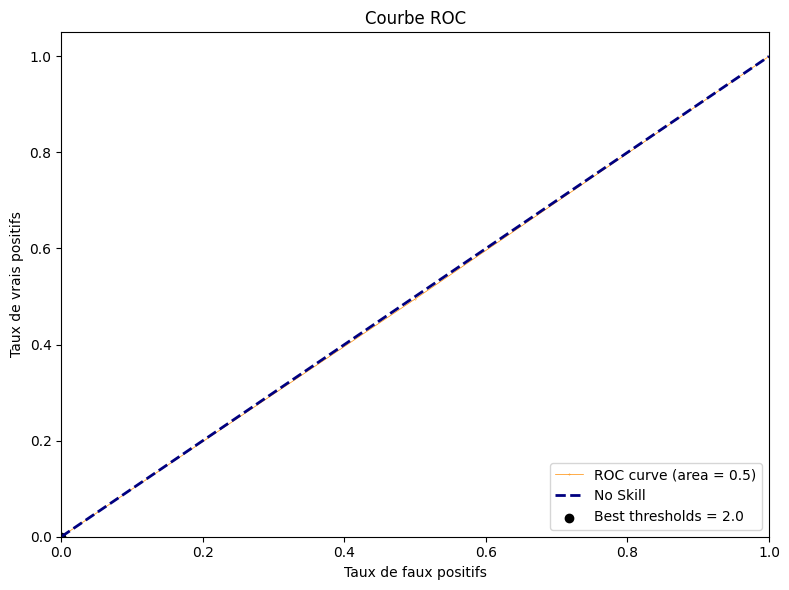

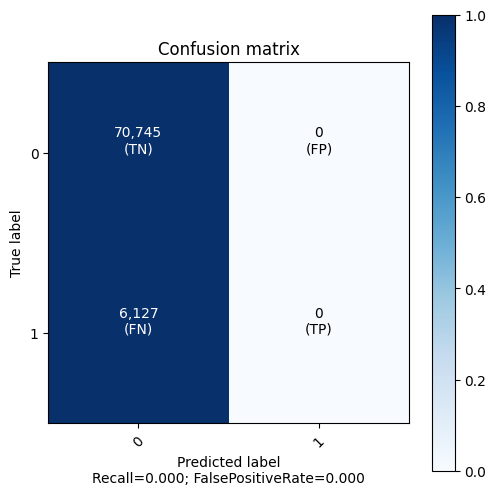

Métrics de performance du modèle:


,accuracy,auc,f1_score,metier_score,temps_fit,temps_predict,seuil_predict
dummy_classifier,0.92,0.5,0.0,0.0,35.64,0.74,2.0


Objets nettoyés :


8645

INFO:pycodestyle:94:10: E131 continuation line unaligned for hanging indent


In [44]:
# Créer un nouvel experiment MLflow et l'activer
creer_et_activer_experience("Comparaison_models")

# Lancez un run MLflow pour le paramètre donné (avec heure de création)
time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
with mlflow.start_run(run_name="dummy_classifier_" + time_str):

    # Instancier le pipeline du modèle
    model_pipe = define_pipeline(
        preprocessor,
        random_seed,
        DummyClassifier(random_state=random_seed)
    )

    # Définir les hyperparamètres à tester
    param_grid = {
        'modele__strategy': ['most_frequent', 'prior', 'stratified', 'uniform']
    }

    # Chargement si fichier pkl de Validation croisée existant
    pkl_file_path = os.path.join(chemin_racine, 'bayes_search_dummy.pkl')
    if os.path.exists(pkl_file_path):
        bayes_search = joblib.load(pkl_file_path)

    # SINON Validation croisée avec recherche d'hyperparamètres (bayesienne)
    else:
        bayes_search = BayesSearchCV(
            model_pipe,
            param_grid,
            cv=cv_skf,
            scoring=metier_score,
            n_jobs=-1,
            random_state=random_seed,
            n_iter=10,
        )
        bayes_search.fit(X_train, y_train)

        # Enregistrer le modèle dans un fichier .pkl
        joblib.dump(bayes_search, pkl_file_path)

    # Résultats de la validation croisée (bayesienne)
    cv_results_clean_df, best_params = process_cv_results(
        bayes_search.cv_results_,
        important_col_cv_results,
        bayes_search,
        sort_column='rank_test_score',
        drop_prefixes=['std_', 'param_']
    )

    # Affichage résultats du bayes_search
    print("Résultats de la validation croisée BayesSearchCV :")
    display(cv_results_clean_df)
    print(f"Best parameters: {best_params}")

    # Sauvegarder le df des resultats dans un fichier CSV
    chemin_results_fichier = (
        os.path.join(chemin_results, "cv_results_clean_df.csv")
    )
    cv_results_clean_df.to_csv(chemin_results_fichier, index=False)

    # Instancier best_model avec les meilleurs hyperparamètres
    model_best_pipe = define_pipeline(
        preprocessor,
        random_seed,
        DummyClassifier(**best_params, random_state=random_seed)
    )

    # Mesurer le temps de fit
    start_time_fit = time.time()
    model_best_pipe.fit(X_train, y_train)
    elapsed_time_fit = time.time() - start_time_fit

    # Calcul des probabilités prédites pour la classe 1 (2ème colonne)
    y_pred_proba = model_best_pipe.predict_proba(X_test)[:, 1]

    # Courbe ROC et détermination du seuil optimal
    fp_rate, best_thresh, auc_score = plot_roc_auc(
        y_test,
        y_pred_proba,
        chemin_figure
    )

    # Mesurer le temps de prediction (avec le seuil optimal)
    start_time_predict = time.time()
    wrapper = CustomModelWrapper(model_best_pipe, threshold=best_thresh)
    y_pred = wrapper.predict(None, X_test)
    elapsed_time_predict = time.time() - start_time_predict

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    chemin_figure_matrix = os.path.join(chemin_figure, "matrix.png")
    plot_confusion_matrix(
        cm,
         ['0', '1'],
        'Confusion matrix',
        save_path=chemin_figure_matrix
    )

    # Calculer les métrics du modele
    metrics = calculer_metrics(
        y_test,
        y_pred,
        auc_score,
        elapsed_time_fit,
        elapsed_time_predict,
        best_thresh
    )

    # Ajouter les meilleurs hyperparamètres à params
    params.update(best_params)

    # Log les paramètres, métrics, artifacts et model à MLflow
    log_mlflow(
        params,
        metrics,
        model_best_pipe,
        chemin_results,
        chemin_figure,
        chemin_data
    )

# Afficher les métrics (en dataframe)
metrics_dummy_df = pd.DataFrame([metrics], index=['dummy_classifier'])
print("Métrics de performance du modèle:")
display(metrics_dummy_df)

# Nettoyer les objets
print("Objets nettoyés :")
gc.collect()

Video aide n°1 :https://www.youtube.com/watch?v=DE1L51Od0mU&ab_channel=AlexLitvinov

Aide n°2 si n°1 ne fonctionne plus :https://www.youtube.com/watch?v=6j_qhTJgB1w&ab_channel=LearnMachineLearning

Nous lançons la commande mlflow ui pour visualiser les résultats de l'expérience.

In [45]:
# # Déterminer l'URI de suivi MLflow (pour google colab ou PC en local)
# if is_google_colab:
#     print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
#     conf.get_default().auth_token = getpass.getpass()
#     port=5000
#     public_url = ngrok.connect(port).public_url
#     print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

# else:
#     !mlflow ui

INFO:pycodestyle:3:80: E501 line too long (94 > 79 characters)


Nous pouvons acceder à l'interface graphique de MLflow en ouvrant une fenêtre vers l'url http://localhost:5000/

# <span style='background:blue'>Etape 3 : Regression logistique</span>

## <span style='background:green'>1/ Validation croisée et optimisation hyperparamètres</span>

Nous utilisons un modèle de **LogisticRegression** de la librairie *scikit-learn* qui est un modèle linéaire simple.

Nous optimisons ses hyperparamètres :
- '**C'** : inverse de la force de régularisation
- '**penalty**' : type de régularisation

## <span style='background:red'>DEV debut</span>

Penser a changer le n_iter = 50!

## <span style='background:red'>DEV fin</span>

Résultats de la validation croisée BayesSearchCV :


,rank_test_score,mean_test_score,params,mean_fit_time,mean_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
3,1,0.63,"{'modele__C': 81.24147487585276, 'modele__pena...",83.18,0.79,0.61,0.62,0.63,0.64,0.62
4,2,0.63,"{'modele__C': 79.95734862630124, 'modele__pena...",81.13,0.77,0.61,0.62,0.63,0.64,0.62
0,3,0.63,"{'modele__C': 41.01629484574285, 'modele__pena...",82.95,0.69,0.61,0.62,0.63,0.64,0.62
1,3,0.63,"{'modele__C': 83.7404616717729, 'modele__penal...",76.35,0.82,0.61,0.62,0.63,0.64,0.62
2,3,0.63,"{'modele__C': 44.48880290499217, 'modele__pena...",75.78,0.82,0.61,0.62,0.63,0.64,0.62
5,3,0.63,"{'modele__C': 73.40546151837698, 'modele__pena...",77.84,0.71,0.61,0.62,0.63,0.64,0.62
6,3,0.63,"{'modele__C': 61.711765056646605, 'modele__pen...",78.59,1.12,0.61,0.62,0.63,0.64,0.62
7,3,0.63,"{'modele__C': 54.34487273835435, 'modele__pena...",75.48,0.87,0.61,0.62,0.63,0.64,0.62
8,3,0.63,"{'modele__C': 95.54824385112973, 'modele__pena...",75.40,0.79,0.61,0.62,0.63,0.64,0.62
9,3,0.63,"{'modele__C': 0.3729944224017752, 'modele__pen...",78.86,0.80,0.61,0.62,0.63,0.64,0.62


Best parameters: {'C': 81.24147487585276, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


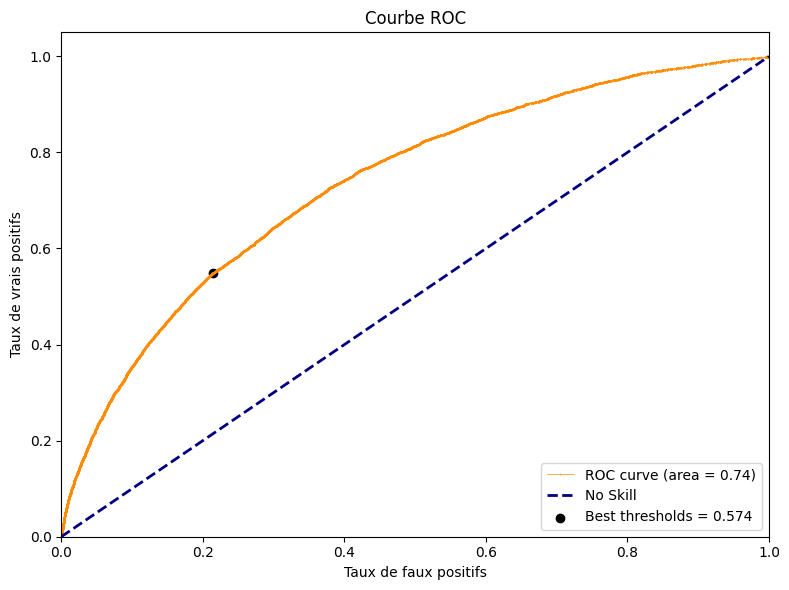

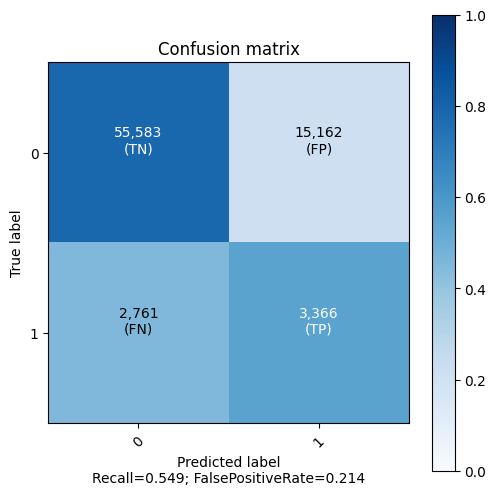

Métrics de performance des modèles:


,accuracy,auc,f1_score,metier_score,temps_fit,temps_predict,seuil_predict
dummy_classifier,0.92,0.50,0.00,0.00,35.64,0.74,2.00
regression_logistic,0.77,0.74,0.27,0.54,73.55,1.74,0.57


Objets nettoyés :


3658

In [46]:
# Créer un nouvel experiment MLflow et l'activer
creer_et_activer_experience("Comparaison_models")

# Lancez un run MLflow pour le paramètre donné (avec heure de création)
time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
with mlflow.start_run(run_name="regression_logistic_" + time_str):

    # Instancier le pipeline du modèle
    model_pipe = define_pipeline(
        preprocessor,
        random_seed,
        LogisticRegression(random_state=random_seed)
    )

    # Définir les hyperparamètres à tester
    param_grid = {
        'modele__C': (0.01, 100),
        'modele__penalty': ['l2', None],
    }

    # Chargement si fichier pkl de Validation croisée existant
    pkl_file_path = os.path.join(chemin_racine, 'bayes_search_rl.pkl')
    if os.path.exists(pkl_file_path):
        bayes_search = joblib.load(pkl_file_path)

    # SINON Validation croisée avec recherche d'hyperparamètres (bayesienne)
    else:
        bayes_search = BayesSearchCV(
            model_pipe,
            param_grid,
            cv=cv_skf,
            scoring=metier_score,
            n_jobs=-1,
            random_state=random_seed,
            n_iter=10,
        )
        bayes_search.fit(X_train, y_train)

        # Enregistrer le modèle dans un fichier .pkl
        joblib.dump(bayes_search, pkl_file_path)

    # Résultats de la validation croisée (bayesienne)
    cv_results_clean_df, best_params = process_cv_results(
        bayes_search.cv_results_,
        important_col_cv_results,
        bayes_search,
        sort_column='rank_test_score',
        drop_prefixes=['std_', 'param_']
    )

    # Affichage résultats du bayes_search
    print("Résultats de la validation croisée BayesSearchCV :")
    display(cv_results_clean_df)
    print(f"Best parameters: {best_params}")

    # Sauvegarder le df des resultats dans un fichier CSV
    chemin_results_fichier = (
        os.path.join(chemin_results, "cv_results_clean_df.csv")
    )
    cv_results_clean_df.to_csv(chemin_results_fichier, index=False)

    # Instancier best_model avec les meilleurs hyperparamètres
    model_best_pipe = define_pipeline(
        preprocessor,
        random_seed,
        LogisticRegression(**best_params, random_state=random_seed)
    )

    # Mesurer le temps de fit
    start_time_fit = time.time()
    model_best_pipe.fit(X_train, y_train)
    elapsed_time_fit = time.time() - start_time_fit

    # Calcul des probabilités prédites pour la classe 1 (2ème colonne)
    y_pred_proba = model_best_pipe.predict_proba(X_test)[:, 1]

    # Courbe ROC et détermination du seuil optimal
    fp_rate, best_thresh, auc_score = plot_roc_auc(
        y_test,
        y_pred_proba,
        chemin_figure
    )

    # Mesurer le temps de prediction (avec le seuil optimal)
    start_time_predict = time.time()
    wrapper = CustomModelWrapper(model_best_pipe, threshold=best_thresh)
    y_pred = wrapper.predict(None, X_test)
    elapsed_time_predict = time.time() - start_time_predict

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    chemin_figure_matrix = os.path.join(chemin_figure, "matrix.png")
    plot_confusion_matrix(
        cm,
        ['0', '1'],
        'Confusion matrix',
        save_path=chemin_figure_matrix
    )

    # Calculer les métrics du modele
    metrics = calculer_metrics(
        y_test,
        y_pred,
        auc_score,
        elapsed_time_fit,
        elapsed_time_predict,
        best_thresh
    )

    # Ajouter les meilleurs hyperparamètres à params
    params.update(best_params)

    # Log les paramètres, métrics, artifacts et model à MLflow
    log_mlflow(
        params,
        metrics,
        model_best_pipe,
        chemin_results,
        chemin_figure,
        chemin_data
    )

# Dataframe des métrics
metrics_rl_df = pd.DataFrame([metrics], index=['regression_logistic'])

# Concaténation des deux df de métrics
metrics_results_df = pd.concat([metrics_dummy_df, metrics_rl_df])

# Afficher le DataFrame combiné
print("Métrics de performance des modèles:")
display(metrics_results_df)

# Nettoyer les objets
print("Objets nettoyés :")
gc.collect()

In [47]:
# # Déterminer l'URI de suivi MLflow (pour google colab ou PC en local)
# if is_google_colab:
#     print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
#     conf.get_default().auth_token = getpass.getpass()
#     port=5000
#     public_url = ngrok.connect(port).public_url
#     print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

# else:
#     !mlflow ui

INFO:pycodestyle:3:80: E501 line too long (94 > 79 characters)


## <span style='background:green'>2/ Feature importance</span>

### <span style='background:purple'>a/ Extraction dataset en array et en dataframe</span>

In [48]:
# X_train
X_train_transformed_array, X_train_transformed_df = extraire_array_df(
    model_best_pipe,
    X_train
)

# X_test
X_test_transformed_array, X_test_transformed_df = extraire_array_df(
    model_best_pipe,
    X_test
)

### <span style='background:purple'>b/ Feature importance locale</span>

### <span style='background:red'>save de Youtube</span>

https://www.youtube.com/watch?v=bdW0e8LF9vI&ab_channel=LeCoinStat

github : https://github.com/LeCoinStat/100JoursDeML/blob/main/05_Apprentissage_Supervise/03_Regularisation/Interpretabilite_Modele_ML.ipynb

Dimension apres explainer.shap_values (76872, 348) 

Dimension shap_values_class_1 (348,) 



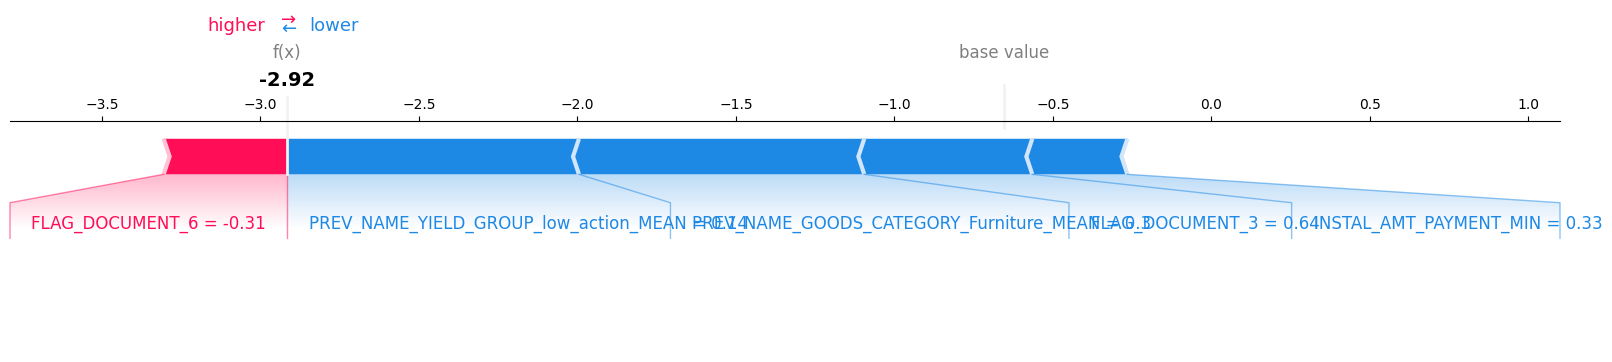

In [89]:
model_shap, explainer, shap_values = plot_feature_importance_locale_rl(
    model_best_pipe,
    X_train_transformed_df,
    X_test_transformed_df,
    i=3,
    nbr_feature=5
)

### <span style='background:purple'>b/ Feature importance globale</span>

Feature importance

Shapley Additive exPlanations (SHAP) :

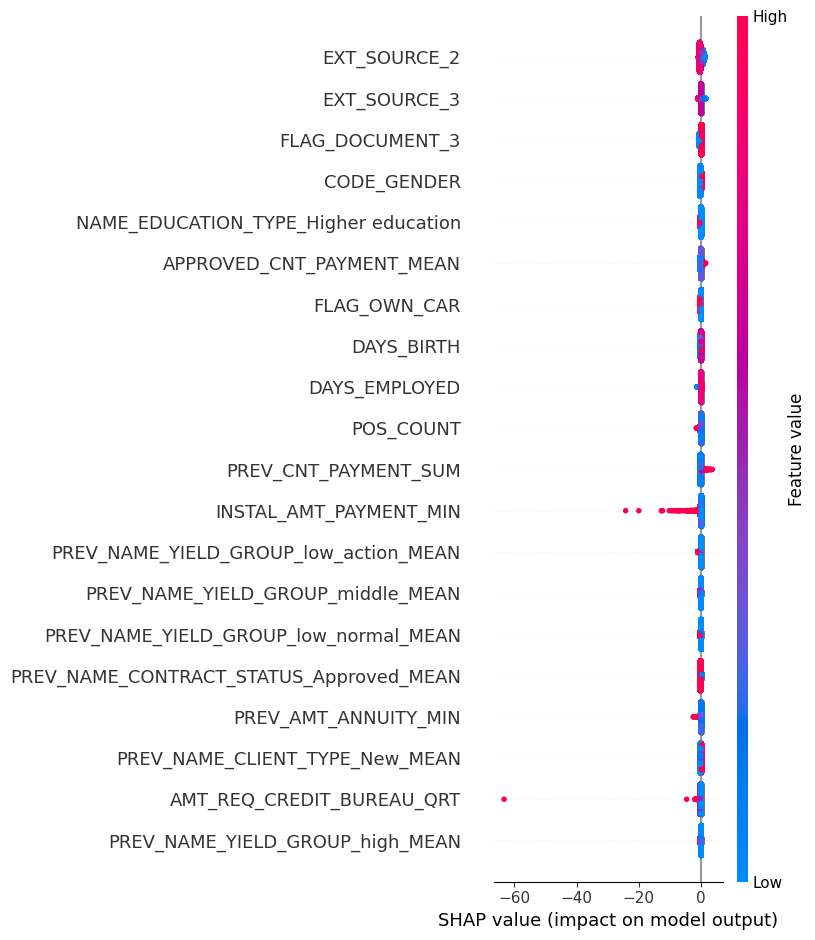

In [92]:
# Graphique SHAP résumé pour l'interprétabilité globale
shap.summary_plot(shap_values, X_test)

# <span style='background:blue'>Etape 4 : Random forest</span>

## <span style='background:green'>1/ Validation croisée et optimisation hyperparamètres</span>

Nous utilisons un modèle de **RandomForestClassifier** de la librairie *scikit-learn* qui est un modèle ensembliste.

Nous optimisons ses hyperparamètres :
- **max_depth**' : profondeur maximale de l'arbre
- **n_estimators**' : nombre d'arbres dans la forêt
- **min_samples_split**' : nombre minimum d'échantillons requis pour diviser un nœud interne

## <span style='background:red'>DEV debut</span>

Penser a changer le n_iter = 50!

## <span style='background:red'>DEV fin</span>

Résultats de la validation croisée BayesSearchCV :


,rank_test_score,mean_test_score,params,mean_fit_time,mean_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
9,1,0.32,"{'modele__max_depth': 5, 'modele__min_samples_...",268.21,1.85,0.33,0.32,0.32,0.31,0.31
2,2,0.29,"{'modele__max_depth': 7, 'modele__min_samples_...",235.05,2.35,0.28,0.28,0.31,0.28,0.28
0,3,0.28,"{'modele__max_depth': 7, 'modele__min_samples_...",458.58,2.71,0.28,0.28,0.29,0.27,0.26
7,4,0.26,"{'modele__max_depth': 8, 'modele__min_samples_...",323.47,1.69,0.27,0.26,0.28,0.25,0.25
6,5,0.26,"{'modele__max_depth': 8, 'modele__min_samples_...",298.21,2.25,0.27,0.26,0.27,0.25,0.24
5,6,0.24,"{'modele__max_depth': 9, 'modele__min_samples_...",284.17,1.78,0.25,0.24,0.26,0.23,0.23
1,7,0.24,"{'modele__max_depth': 9, 'modele__min_samples_...",322.45,2.08,0.24,0.24,0.25,0.23,0.23
4,8,0.24,"{'modele__max_depth': 9, 'modele__min_samples_...",362.48,2.35,0.24,0.24,0.25,0.23,0.23
3,9,0.24,"{'modele__max_depth': 9, 'modele__min_samples_...",380.27,2.12,0.25,0.24,0.25,0.22,0.22
8,10,0.22,"{'modele__max_depth': 10, 'modele__min_samples...",451.22,2.17,0.23,0.22,0.22,0.20,0.21


Best parameters: {'max_depth': 5, 'min_samples_split': 9, 'n_estimators': 87}


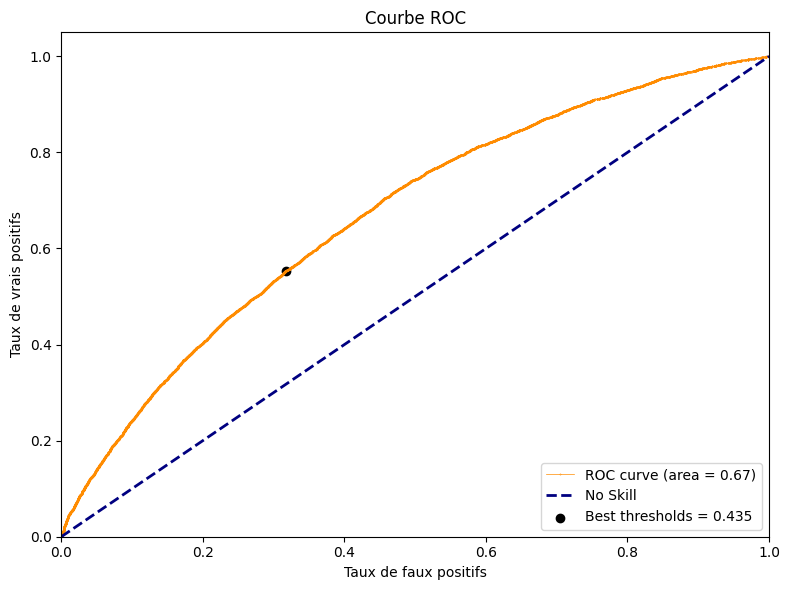

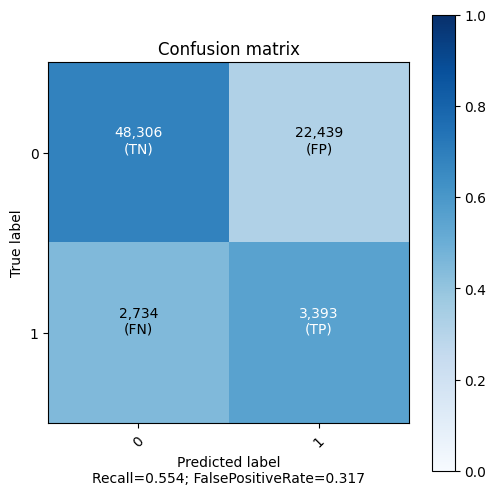

Métrics de performance des modèles:


,accuracy,auc,f1_score,metier_score,temps_fit,temps_predict,seuil_predict
dummy_classifier,0.92,0.50,0.00,0.00,35.64,0.74,2.00
regression_logistic,0.77,0.74,0.27,0.54,73.55,1.74,0.57
random_forest,0.67,0.67,0.21,0.54,172.34,1.28,0.43


Objets nettoyés :


54333

In [95]:
# Créer un nouvel experiment MLflow et l'activer
creer_et_activer_experience("Comparaison_models")

# Lancez un run MLflow pour le paramètre donné (avec heure de création)
time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
with mlflow.start_run(run_name="random_forest_" + time_str):

    # Instancier le pipeline du modèle
    model_pipe = define_pipeline(
        preprocessor,
        random_seed,
        RandomForestClassifier(random_state=random_seed)
    )

    # Définir les hyperparamètres à tester
    param_grid = {
        'modele__max_depth': (5, 10),
        'modele__n_estimators': (50, 100),
        'modele__min_samples_split': (5, 10)
    }

    # Chargement si fichier pkl de Validation croisée existant
    pkl_file_path = os.path.join(chemin_racine, 'bayes_search_rf.pkl')
    if os.path.exists(pkl_file_path):
        bayes_search = joblib.load(pkl_file_path)

    # SINON Validation croisée avec recherche d'hyperparamètres (bayesienne)
    else:
        bayes_search = BayesSearchCV(
            model_pipe,
            param_grid,
            cv=cv_skf,
            scoring=metier_score,
            n_jobs=-1,
            random_state=random_seed,
            n_iter=10,
        )
        bayes_search.fit(X_train, y_train)

        # Enregistrer le modèle dans un fichier .pkl
        joblib.dump(bayes_search, pkl_file_path)

    # Résultats de la validation croisée (bayesienne)
    cv_results_clean_df, best_params = process_cv_results(
        bayes_search.cv_results_,
        important_col_cv_results,
        bayes_search,
        sort_column='rank_test_score',
        drop_prefixes=['std_', 'param_']
    )

    # Affichage résultats du bayes_search
    print("Résultats de la validation croisée BayesSearchCV :")
    display(cv_results_clean_df)
    print(f"Best parameters: {best_params}")

    # Sauvegarder le df des resultats dans un fichier CSV
    chemin_results_fichier = (
        os.path.join(chemin_results, "cv_results_clean_df.csv")
    )
    cv_results_clean_df.to_csv(chemin_results_fichier, index=False)

    # Instancier best_model avec les meilleurs hyperparamètres
    model_best_pipe = define_pipeline(
        preprocessor,
        random_seed,
        RandomForestClassifier(**best_params, random_state=random_seed)
    )

    # Mesurer le temps de fit
    start_time_fit = time.time()
    model_best_pipe.fit(X_train, y_train)
    elapsed_time_fit = time.time() - start_time_fit

    # Calcul des probabilités prédites pour la classe 1 (2ème colonne)
    y_pred_proba = model_best_pipe.predict_proba(X_test)[:, 1]

    # Courbe ROC et détermination du seuil optimal
    fp_rate, best_thresh, auc_score = plot_roc_auc(
        y_test,
        y_pred_proba,
        chemin_figure
    )

    # Mesurer le temps de prediction (avec le seuil optimal)
    start_time_predict = time.time()
    wrapper = CustomModelWrapper(model_best_pipe, threshold=best_thresh)
    y_pred = wrapper.predict(None, X_test)
    elapsed_time_predict = time.time() - start_time_predict

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    chemin_figure_matrix = os.path.join(chemin_figure, "matrix.png")
    plot_confusion_matrix(
        cm,
        ['0', '1'],
        'Confusion matrix',
        save_path=chemin_figure_matrix
    )

    # Calculer les métrics du modele
    metrics = calculer_metrics(
        y_test,
        y_pred,
        auc_score,
        elapsed_time_fit,
        elapsed_time_predict,
        best_thresh
    )

    # Ajouter les meilleurs hyperparamètres à params
    params.update(best_params)

    # Log les paramètres, métrics, artifacts et model à MLflow
    log_mlflow(
        params,
        metrics,
        model_best_pipe,
        chemin_results,
        chemin_figure,
        chemin_data
    )

# Dataframe des métrics
metrics_rf_df = pd.DataFrame([metrics], index=['random_forest'])

# Concaténation des deux df de métrics
metrics_results_df = pd.concat([metrics_results_df, metrics_rf_df])

# Afficher le DataFrame combiné
print("Métrics de performance des modèles:")
display(metrics_results_df)

# Nettoyer les objets
print("Objets nettoyés :")
gc.collect()

In [53]:
# # Déterminer l'URI de suivi MLflow (pour google colab ou PC en local)
# if is_google_colab:
#     print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
#     conf.get_default().auth_token = getpass.getpass()
#     port=5000
#     public_url = ngrok.connect(port).public_url
#     print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

# else:
#     !mlflow ui

INFO:pycodestyle:3:80: E501 line too long (94 > 79 characters)


## <span style='background:green'>2/ Feature importance</span>

### <span style='background:purple'>a/ Extraction dataset en array et en dataframe</span>

In [96]:
# X_train
X_train_transformed_array, X_train_transformed_df = extraire_array_df(
    model_best_pipe,
    X_train
)

# X_test
X_test_transformed_array, X_test_transformed_df = extraire_array_df(
    model_best_pipe,
    X_test
)

### <span style='background:purple'>b/ Feature importance locale</span>

In [55]:
# i=3
# nbr_feature=5

# # Initialiser JavaScript
# shap.initjs()

# # Récupérer le modèle à partir du pipeline
# model_shap = model_best_pipe.named_steps['modele']

# # Créer l'explainer en fonction du type de modèle
# explainer = shap.TreeExplainer(model_shap)

# # Calculer les valeurs SHAP des données de test
# shap_values = explainer.shap_values(X_test_transformed_df_frac)

# # DEV
# shap_values_reordered = np.transpose(shap_values, (2, 0, 1))
# display('Dimension apres explainer.shap_values', shap_values.shape)
# display('Dimension apres reorder', shap_values_reordered.shape)

# shap_values_reordered_df = pd.DataFrame(shap_values_reordered[0], columns=X_test_transformed_df_frac.columns)
# display(shap_values_reordered_df)

# shap_values_class_1 = shap_values_reordered[1]

# # Créer un DataFrame avec les valeurs SHAP
# shap_values_df_frac = pd.DataFrame(
#     shap_values_class_1,
#     columns=X_test_transformed_df_frac.columns
# )

# # Calculer la valeur absolue des valeurs SHAP
# abs_shap_values = shap_values_df.abs()

# # Obtenir les noms des nbr_feature ayant les valeurs SHAP les plus élevées
# top_features = (
#     abs_shap_values
#     .sum()
#     .sort_values(ascending=False)
#     .head(nbr_feature)
#     .index
# )

# # Sélectionner les top_features de X_test et shap_values_df (arrondis)
# X_test_subset = X_test_transformed_df_frac[top_features].round(3)
# shap_values_subset = shap_values_df_frac[top_features].values.round(3)

# # Afficher les valeurs SHAP pour les top_features
# force_plot = shap.force_plot(
#     explainer.expected_value[1],
#     shap_values_subset[i, :],
#     X_test_subset.iloc[i, :],
#     matplotlib=True
# )

INFO:pycodestyle:21:80: E501 line too long (111 > 79 characters)


Dimension apres explainer.shap_values (76872, 348, 2) 

Dimension apres reorder (2, 76872, 348) 

Dimension shap_values_class_1 (76872, 348) 



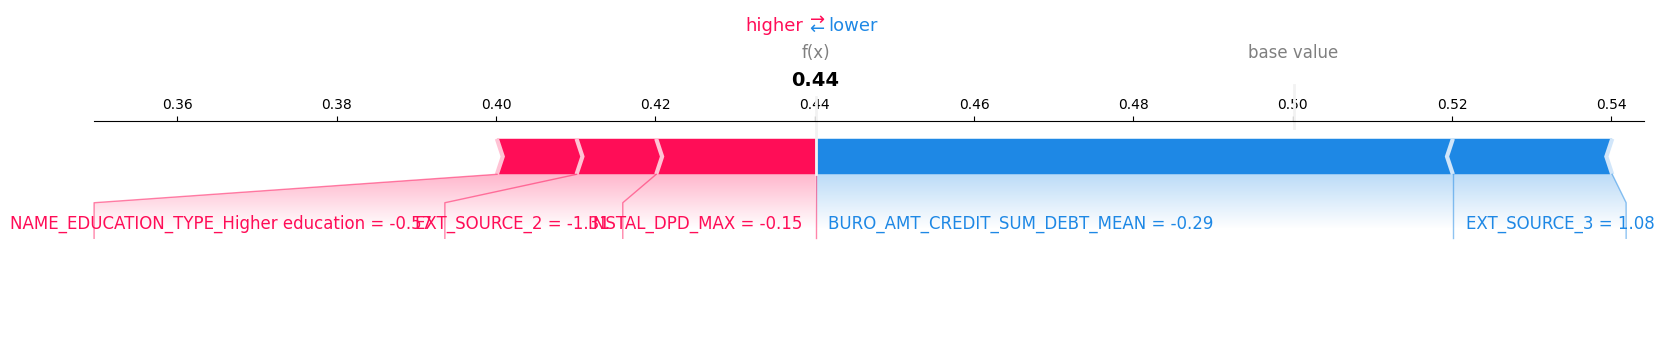

In [97]:
model_shap, explainer, shap_values = plot_feature_importance_locale_tree(
    model_best_pipe,
    X_train_transformed_df,
    X_test_transformed_df,
    i=3,
    nbr_feature=5
)

### <span style='background:purple'>c/ Feature importance globale</span>

Feature importance

Shapley Additive exPlanations (SHAP) :

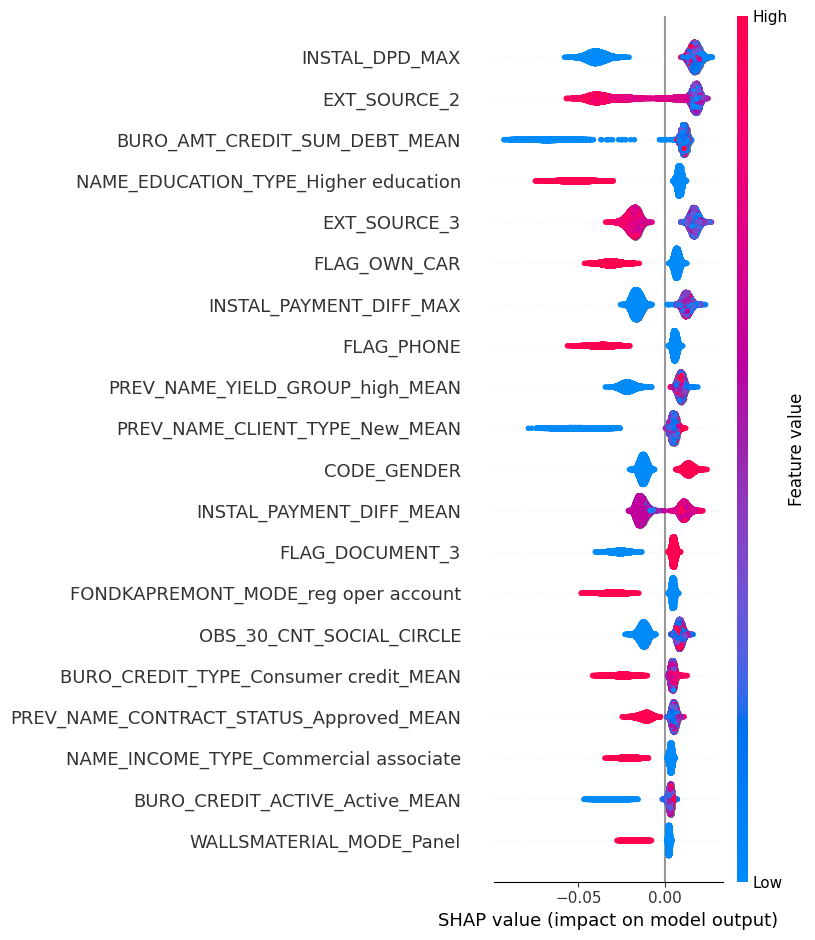

In [98]:
# Graphique SHAP résumé pour l'interprétabilité globale
shap.summary_plot(shap_values, X_test)

# <span style='background:blue'>Etape 5 : Light GBM</span>

## <span style='background:green'>1/ Validation croisée et optimisation hyperparamètres</span>

Nous utilisons un modèle de **LGBMClassifier** de la librairie *lightgbm* qui est un modèle ensembliste.

Nous optimisons ses hyperparamètres :
- **max_depth**' : profondeur maximale de l'arbre
- **n_estimators**' : nombre d'arbres dans la forêt
- **learning_rate**' : taux d'apprentissage

## <span style='background:red'>DEV debut</span>

Penser a changer le n_iter = 50!

## <span style='background:red'>DEV fin</span>

Résultats de la validation croisée BayesSearchCV :


,rank_test_score,mean_test_score,params,mean_fit_time,mean_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
8,1,0.04,"{'modele__learning_rate': 0.19554779863099284,...",123.02,1.17,0.04,0.04,0.05,0.04,0.04
0,2,0.04,"{'modele__learning_rate': 0.1410103958853314, ...",131.78,1.89,0.03,0.04,0.04,0.03,0.03
4,3,0.03,"{'modele__learning_rate': 0.17995534416071732,...",113.58,1.63,0.04,0.04,0.03,0.03,0.03
7,4,0.03,"{'modele__learning_rate': 0.15434030676903127,...",118.78,1.39,0.03,0.04,0.03,0.03,0.03
1,5,0.03,"{'modele__learning_rate': 0.18373883555532844,...",116.44,1.29,0.03,0.03,0.03,0.03,0.03
3,6,0.03,"{'modele__learning_rate': 0.18123959883573634,...",109.94,1.33,0.03,0.03,0.03,0.03,0.03
6,7,0.03,"{'modele__learning_rate': 0.16170793585023163,...",112.04,1.61,0.03,0.03,0.03,0.03,0.03
5,8,0.03,"{'modele__learning_rate': 0.17340280179855683,...",106.49,1.51,0.03,0.03,0.03,0.02,0.03
9,9,0.02,"{'modele__learning_rate': 0.10036303072547433,...",122.65,1.24,0.02,0.03,0.02,0.02,0.02
2,10,0.02,"{'modele__learning_rate': 0.14448325123011518,...",112.65,1.47,0.02,0.02,0.02,0.02,0.02


Best parameters: {'learning_rate': 0.19554779863099284, 'max_depth': 9, 'n_estimators': 94}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 211920, number of negative: 211920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.522123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58875
[LightGBM] [Info] Number of data points in the train set: 423840, number of used features: 335
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


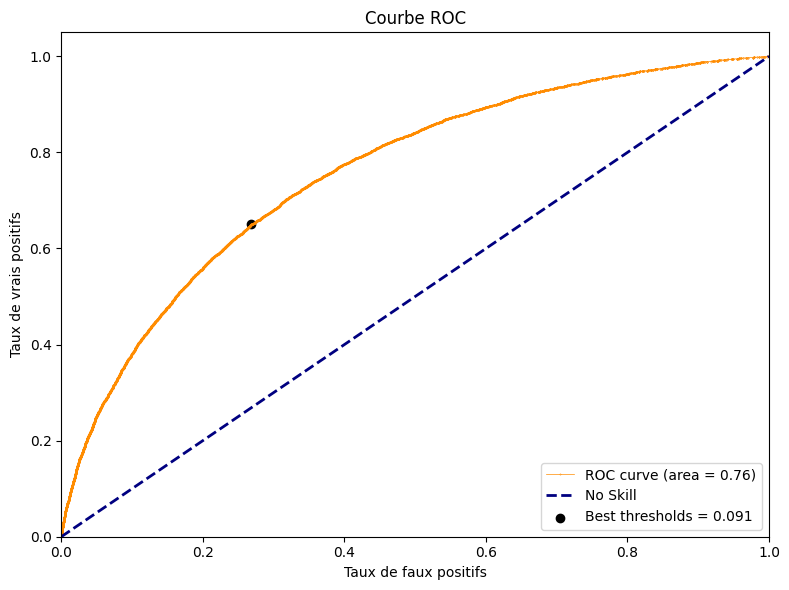

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


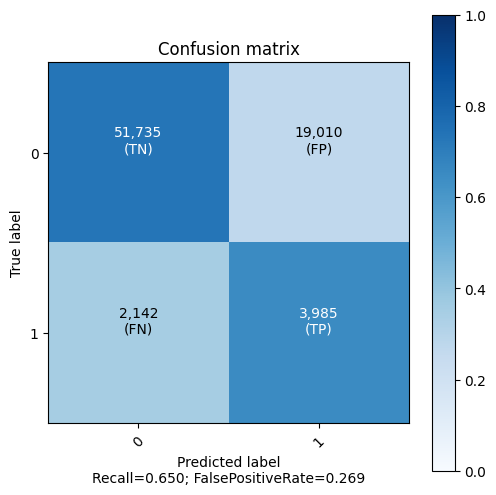

Métrics de performance des modèles:


,accuracy,auc,f1_score,metier_score,temps_fit,temps_predict,seuil_predict
dummy_classifier,0.92,0.50,0.00,0.00,35.64,0.74,2.00
regression_logistic,0.77,0.74,0.27,0.54,73.55,1.74,0.57
random_forest,0.67,0.67,0.21,0.54,172.34,1.28,0.43
light_gbm,0.72,0.76,0.27,0.63,73.64,1.29,0.09


Objets nettoyés :


21833

In [99]:
# Créer un nouvel experiment MLflow et l'activer
creer_et_activer_experience("Comparaison_models")

# Lancez un run MLflow pour le paramètre donné (avec heure de création)
time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
with mlflow.start_run(run_name="light_gbm_" + time_str):

    # Instancier le pipeline du modèle
    model_pipe = define_pipeline(
        preprocessor,
        random_seed,
        LGBMClassifier(random_state=random_seed)
    )

    # Définir les hyperparamètres à tester
    param_grid = {
        'modele__max_depth': (5, 10),
        'modele__n_estimators': (50, 100),
        'modele__learning_rate': (0.1, 0.2)
    }

    # Chargement si fichier pkl de Validation croisée existant
    pkl_file_path = os.path.join(chemin_racine, 'bayes_search_gbm.pkl')
    if os.path.exists(pkl_file_path):
        bayes_search = joblib.load(pkl_file_path)

    # SINON Validation croisée avec recherche d'hyperparamètres (bayesienne)
    else:
        bayes_search = BayesSearchCV(
            model_pipe,
            param_grid,
            cv=cv_skf,
            scoring=metier_score,
            n_jobs=-1,
            random_state=random_seed,
            n_iter=10,
        )
        bayes_search.fit(X_train, y_train)

        # Enregistrer le modèle dans un fichier .pkl
        joblib.dump(bayes_search, pkl_file_path)

    # Résultats de la validation croisée (bayesienne)
    cv_results_clean_df, best_params = process_cv_results(
        bayes_search.cv_results_,
        important_col_cv_results,
        bayes_search,
        sort_column='rank_test_score',
        drop_prefixes=['std_', 'param_']
    )

    # Affichage résultats du bayes_search
    print("Résultats de la validation croisée BayesSearchCV :")
    display(cv_results_clean_df)
    print(f"Best parameters: {best_params}")

    # Sauvegarder le df des resultats dans un fichier CSV
    chemin_results_fichier = (
        os.path.join(chemin_results, "cv_results_clean_df.csv")
    )
    cv_results_clean_df.to_csv(chemin_results_fichier, index=False)

    # Instancier best_model avec les meilleurs hyperparamètres
    model_best_pipe = define_pipeline(
        preprocessor,
        random_seed,
        LGBMClassifier(**best_params, random_state=random_seed)
    )

    # Mesurer le temps de fit
    start_time_fit = time.time()
    model_best_pipe.fit(X_train, y_train)
    elapsed_time_fit = time.time() - start_time_fit

    # Calcul des probabilités prédites pour la classe 1 (2ème colonne)
    y_pred_proba = model_best_pipe.predict_proba(X_test)[:, 1]

    # Courbe ROC et détermination du seuil optimal
    fp_rate, best_thresh, auc_score = plot_roc_auc(
        y_test,
        y_pred_proba,
        chemin_figure
    )

    # Mesurer le temps de prediction (avec le seuil optimal)
    start_time_predict = time.time()
    wrapper = CustomModelWrapper(model_best_pipe, threshold=best_thresh)
    y_pred = wrapper.predict(None, X_test)
    elapsed_time_predict = time.time() - start_time_predict

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    chemin_figure_matrix = os.path.join(chemin_figure, "matrix.png")
    plot_confusion_matrix(
        cm,
        ['0', '1'],
        'Confusion matrix',
        save_path=chemin_figure_matrix
    )

    # Calculer les métrics du modele
    metrics = calculer_metrics(
        y_test,
        y_pred,
        auc_score,
        elapsed_time_fit,
        elapsed_time_predict,
        best_thresh
    )

    # Ajouter les meilleurs hyperparamètres à params
    params.update(best_params)

    # Log les paramètres, métrics, artifacts et model à MLflow
    log_mlflow(
        params,
        metrics,
        model_best_pipe,
        chemin_results,
        chemin_figure,
        chemin_data
    )

# Dataframe des métrics
metrics_lgbm_df = pd.DataFrame([metrics], index=['light_gbm'])

# Concaténation des deux df de métrics
metrics_results_df = pd.concat([metrics_results_df, metrics_lgbm_df])

# Afficher le DataFrame combiné
print("Métrics de performance des modèles:")
display(metrics_results_df)

# Nettoyer les objets
print("Objets nettoyés :")
gc.collect()

In [60]:
# # Déterminer l'URI de suivi MLflow (pour google colab ou PC en local)
# if is_google_colab:
#     print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
#     conf.get_default().auth_token = getpass.getpass()
#     port=5000
#     public_url = ngrok.connect(port).public_url
#     print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

# else:
#     !mlflow ui

INFO:pycodestyle:3:80: E501 line too long (94 > 79 characters)


## <span style='background:green'>2/ Feature importance</span>

### <span style='background:purple'>a/ Extraction dataset en array et en dataframe</span>

In [100]:
# X_train
X_train_transformed_array, X_train_transformed_df = extraire_array_df(
    model_best_pipe,
    X_train
)

# X_test
X_test_transformed_array, X_test_transformed_df = extraire_array_df(
    model_best_pipe,
    X_test
)

### <span style='background:purple'>b/ Feature importance locale</span>

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Dimension apres explainer.shap_values (76872, 348) 

Dimension shap_values_class_1 (348,) 



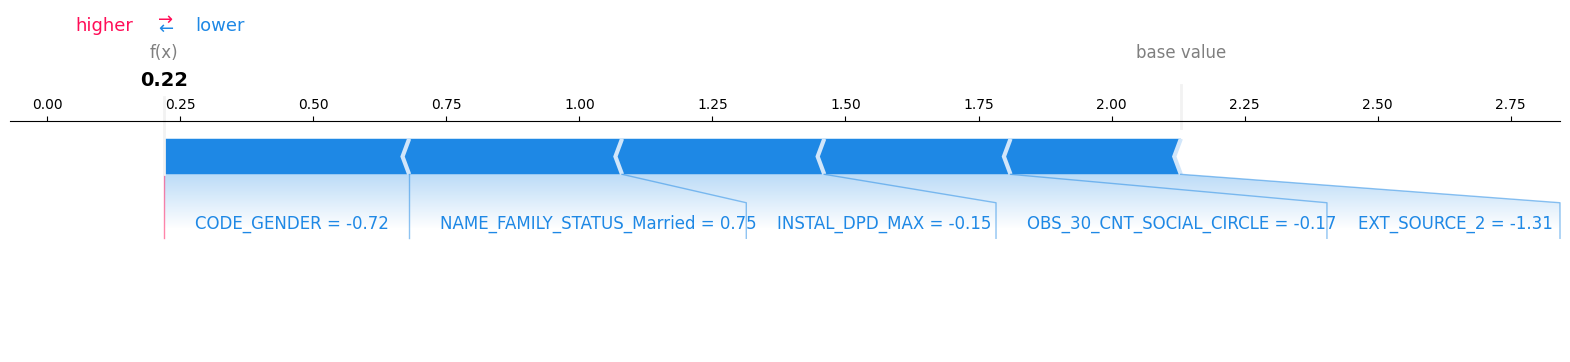

In [101]:
model_shap, explainer, shap_values = plot_feature_importance_locale_gbm(
    model_best_pipe,
    X_train_transformed_df,
    X_test_transformed_df,
    i=3,
    nbr_feature=5
)

### <span style='background:purple'>c/ Feature importance globale</span>

Feature importance

Shapley Additive exPlanations (SHAP) :

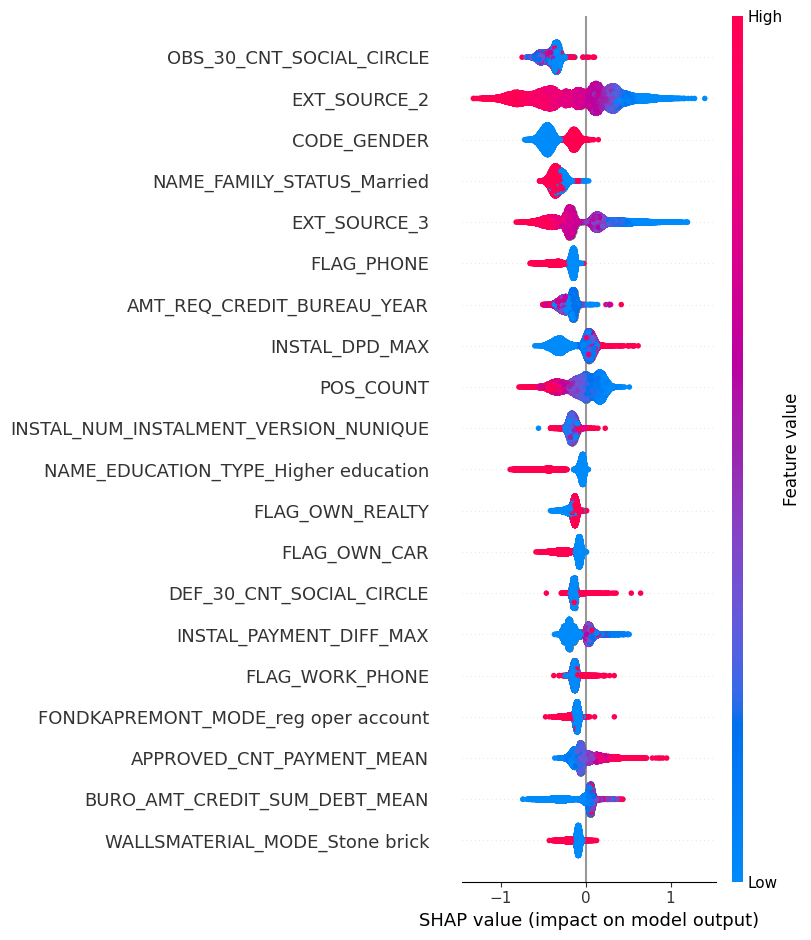

In [102]:
# Graphique SHAP résumé pour l'interprétabilité globale
shap.summary_plot(shap_values, X_test)

# <span style='background:blue'>Etape 6 : Enregistrement du meilleur modèle</span>

## <span style='background:green'>1/ Importation modèle</span>

Nous importons le meilleur modele à partir du run de MLflow.

In [ ]:
# L'URI du modèle
model_uri = 'runs:/cab6a3755e5841b1987c95fa3b92f753/model_best'

# Charger le modèle
model_light_gbm_best = mlflow.sklearn.load_model(model_uri)
display(model_light_gbm_best)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_encoder',
                                                                   TargetEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GE...
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'YEARS_BEGINEXPLUATATION_AVG',
                                                   'FLOORSMAX_AVG',
                                                   'OBS_30_CNT_SOCIAL_CIRCLE',
                                                   'DEF_30_CNT_SOCIAL_CIRCLE',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'FLAG_DOCUMENT_2', ...])])),
                ('sampling', SMOTE(random_state=42)),
                ('modele',
                 LGBMClassifier(learning_rate=0.19554779863099284, max_depth=9,
                                n_estimators=94, random_state=42))])

## <span style='background:green'>2/ Enregistrement modèle</span>

### <span style='background:purple'>a/ Methode 1 : joblib</span>

Nous pouvons sérialiser le pipeline du meilleur modèle avec **joblib** mais cela n'enregistre pas les metadonnées du modèle.

In [ ]:
# joblib.dump(model_light_gbm_best, 'model_light_gbm_best.joblib')

### <span style='background:purple'>b/ Methode 2 : save_model</span>

Nous enregistrons le modèle avec mlflow.sklearn. Cela se fait en 2 étapes :

**1. Créer la signature du modèle :**

In [ ]:
# signature = infer_signature(X_train, y_train)

**2. Enregistrer le modèle en indiquant 3 infos:**
- Nom du modèle
- Chemin du dossier où va être enregistré le modèle
- Signature du modèle

In [ ]:
# mlflow.sklearn.save_model(
#     model_light_gbm_best,
#     'mlflow_model',
#     signature=signature
# )

Nous pouvons visualiser les inputs et les outputs du modèle :

In [ ]:
# # Inputs
# input_schema_df = pd.DataFrame(
#     [(col.name, col.type) for col in signature.inputs],
#     columns=['column', 'type']
# )
# display(input_schema_df)

# # Outputs
# output_schema_df = pd.DataFrame(
#     [(col.name, col.type) for col in signature.outputs],
#     columns=['column', 'type']
# )
# display(output_schema_df)

### <span style='background:purple'>c/ Methode 3 : register_model</span>

Nous enregistrons le modèle dans le MLflow Model Registry.

In [ ]:
# Enregistrer le modèle dans le MLflow Model Registry
model_name = "model_light_gbm_best"
model_version = mlflow.register_model(model_uri, model_name)

Successfully registered model 'model_light_gbm_best'.
Created version '1' of model 'model_light_gbm_best'.


Toutes ces informations sont enregistrées dans un repository **MLflow** accessible [ici](http://localhost:5000/).

In [103]:
# Déterminer l'URI de suivi MLflow (pour google colab ou PC en local)
if is_google_colab:
    print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
    conf.get_default().auth_token = getpass.getpass()
    port = 5000
    public_url = ngrok.connect(port).public_url
    print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

else:
    !mlflow ui

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


INFO:pycodestyle:3:80: E501 line too long (92 > 79 characters)


 * ngrok tunnel "https://cb28-35-185-57-51.ngrok-free.app" -> "http://127.0.0.1:5000"


# <span style='background:blue'>Conclusions</span>

In [ ]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

**Définir la stratégie d’élaboration d’un modèle d’apprentissage supervisé et sélectionner et entraîner des modèles adaptés à une problématique métier afin de réaliser une analyse prédictive.**

~~CE1 Les variables catégorielles identifiées ont été transformées en fonction du besoin (par exemple via OneHotEncoder ou TargetEncoder).~~

~~CE2 Vous avez a créé de nouvelles variables à partir de variables existantes.~~

~~CE3 Vous avez réalisé des transformations mathématiques lorsque c'est requis pour transformer les distributions de variables.~~

~~CE4 Vous avez normalisé les variables lorsque c'est requis.~~

~~CE5 Vous avez défini sa stratégie d’élaboration d’un modèle pour répondre à un besoin métier. Cela signifie dans ce projet que : l’étudiant a présenté son approche méthodologique de modélisation dans son support de présentation pendant la soutenance et est capable de répondre à des questions à ce sujet, si elles lui sont posées.~~

~~CE6 Vous avez choisi la ou les variables cibles pertinentes.~~

~~CE7 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle).~~

~~CE8 Vous avez testé plusieurs algorithmes de façon cohérente, en partant des plus simples vers les plus complexes (au minimum un linéaire et un non linéaire).~~

**Évaluer les performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.**

~~CE1 Vous avez choisi une métrique adaptée pour évaluer la performance d'un algorithme (par exemple : R2 ou RMSE en régression, accuracy ou AUC en classification, etc.). Dans le cadre de ce projet, cela signifie que : Vous avez mis en oeuvre un score métier pour évaluer les modèles et optimiser les hyperparamètres, qui prend en compte les spécificités du contexte, en particulier le fait que le coût d’un faux négatif et d’un faux positif sont sensiblement différents.~~

~~CE2 Vous avez exploré d'autres indicateurs de performance que le score pour comprendre les résultats (coefficients des variables en fonction de la pénalisation, visualisation des erreurs en fonction des variables du modèle, temps de calcul...).~~

~~CE3 Vous avez séparé les données en train/test pour les évaluer de façon pertinente et détecter l'overfitting.~~

~~CE4 Vous avez mis en place un modèle simple de référence pour évaluer le pouvoir prédictif du modèle choisi (dummyRegressor ou dummyClassifier).~~

~~CE5 Vous avez pris en compte dans sa démarche de modélisation l'éventuel déséquilibre des classes (dans le cas d'une classification).~~

~~CE6 Vous avez optimisé les hyper-paramètres pertinents dans les différents algorithmes.~~

CE7 Vous avez mis en place une validation croisée (via GridsearchCV, RandomizedSearchCV ou équivalent) afin d’optimiser les hyperparamètres et comparer les modèles. Dans le cadre de ce projet :

- Une cross-validation du dataset train est réalisée,
- Un premier test de différentes valeurs d’hyperparamètres est réalisé sur chaque algorithme testé, et affiné pour l’algorithme final choisi,
- Tout projet présentant un score AUC anormalement élevé, démontrant de l’overfitting dans le GrisSearchCV, sera invalidé (il ne devrait pas être supérieur au meilleur de la compétition Kaggle : 0.82).

CE8 Vous avez présenté l'ensemble des résultats en allant des modèles les plus simples aux plus complexes. Vous avez justifié le choix final de l'algorithme et des hyperparamètres.

CE9 Vous avez réalisé l’analyse de l’importance des variables (feature importance) globale sur l’ensemble du jeu de données et locale sur chaque individu du jeu de données.

**Définir et mettre en œuvre un pipeline d’entraînement des modèles, avec centralisation du stockage des modèles et formalisation des résultats et mesures des différentes expérimentations réalisées, afin d’industrialiser le projet de Machine Learning.**

~~CE1 Vous avez mis en oeuvre un pipeline d’entraînement des modèles reproductible.~~

~~CE2 Vous avez sérialisé et stocké les modèles créés dans un registre centralisé afin de pouvoir facilement les réutiliser.~~

CE3 Vous avez formalisé des mesures et résultats de chaque expérimentation, afin de les analyser et de les comparer

## <span style='background:red'>POST test</span>


Il suffit de Run le fichier 'dashboard.py' streamlit dans la console pour visualiser le tableau de bord streamlit

In [ ]:
# !Streamlit run dashboard.py